In [1]:
# binder https://hub.gke.mybinder.org/user/blychs-climatologia_fisica-dckeuhha/notebooks/practica2.ipynb
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import xarray as xr
import copy
from metpy.units import units
import metpy.calc as mpcalc
import metpy.constants as mpconsts
import datetime as dt
import calendar
import seaborn as sns
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [2]:
def load_mask(dataarray):
    """ Carga máscaras de tiempo de NDJFM y MJJAS"""
    mask_ndjfm = ((dataarray.time.dt.month == 11) + (dataarray.time.dt.month == 12) +
                        (dataarray.time.dt.month == 1) + (dataarray.time.dt.month == 2) +
                        (dataarray.time.dt.month == 3))
    mask_mjjas = ((dataarray.time.dt.month == 5) + (dataarray.time.dt.month == 6) +
                        (dataarray.time.dt.month == 7) + (dataarray.time.dt.month == 8) +
                        (dataarray.time.dt.month == 9))
    return mask_ndjfm, mask_mjjas


def set_monsoon_area(dataarray, method='IPCC', hemisphere='SH', num_years=30):
    """
    Calcula el área monzónica. Devuelve el rango de precipitaciones en el monzón
    y una máscara que vale 1 donde hay monzón y cero donde no.""" 
    dataoutput = dataarray
    if method == 'IPCC':
        if hemisphere == 'SH':
            mask_lat = (dataarray.lat < 0)
            mask_summer = load_mask(dataoutput)[0]
            monthly_days_summer = 30.25
            mask_winter = load_mask(dataoutput)[1]
            monthly_days_winter = 30.6
        elif hemisphere == 'NH':
            mask_lat = (dataarray.lat > 0)
            mask_summer = load_mask(dataoutput)[1]
            monthly_days_summer = 30.6
            mask_winter = load_mask(dataoutput)[0]
            monthly_days_winter = 30.25
        difference = ((dataoutput.where(mask_summer).mean(dim='time') / monthly_days_summer)  - 
                       (dataoutput.where(mask_winter).mean(dim='time') / monthly_days_winter))
        monsoon_area = difference.where(mask_lat).where(difference > 2.5)
        mask_monsoon = monsoon_area.notnull()
    if method == 'Hsu':
        if hemisphere == 'SH':
            mask_lat = (dataarray.lat < 0)
            mask_summer = (dataarray.time.dt.season == 'DJF')
            mask_winter = (dataarray.time.dt.season == 'JJA')
        if hemisphere == 'NH':
            mask_lat = (dataarray.lat > 0)
            mask_summer = (dataarray.time.dt.season == 'JJA')
            mask_winter = (dataarray.time.dt.season == 'DJF')
        percentage = (dataoutput.where(mask_summer).sum(dim='time') / dataoutput.sum(dim='time')) * 100
        monsoon_area = percentage.where(mask_lat).where((dataoutput.where(mask_summer).sum(dim='time') - 
                                                         (dataoutput.where(mask_winter).sum(dim='time')))/num_years > 180)
        mask_monsoon = monsoon_area.notnull()
        # GMP = xr.ones(mask_monsoon)
    # elif method == 'Hsu':
    #     if hemisphere
    return monsoon_area, mask_monsoon# , GMP


def ploteo_general(dataarray, title=None, vmin=None, vmax=None, projection=ccrs.PlateCarree(), figsize=(20,10),
                   extend='max', cmap=None, under='none', over=False):
    plt.figure(figsize=(figsize))
    ax = plt.axes(projection=ccrs.PlateCarree())
    if cmap != None:
        ploteo = dataarray.plot(vmin=vmin, vmax=vmax, extend=extend, ax=ax, cmap=cmap)
    else:
        ploteo = dataarray.plot(vmin=vmin, vmax=vmax, extend=extend, ax=ax)
    cmap = ploteo.get_cmap()
    cmap2 = copy.copy(cmap)
    if under != 'none':
        cmap=cmap2 
    if over == True:
        cmap.set_over(over)
    ax.coastlines()
    plt.title(title)
    ax.add_feature(cfeature.BORDERS)
    return ax


In [3]:

def load_file(path):
    """
    Carga archivo/s y devuelve:
    Ensamble, ensamble en NDJFM, ensamble en MJJAS, media, media en NDJFM, media en MJJAS"""
    file_dict = {}
    ds = xr.open_mfdataset(path, combine='nested', concat_dim='ensemble').mean(dim='ensemble')
    file_dict['ds'] = ds
    file_dict['ndjfm'] = ds.where(load_mask(ds)[0])
    file_dict['mjjas'] = ds.where(load_mask(ds)[1])
    file_dict['mean'] = ds.mean(dim='time')
    file_dict['mean_ndjfm'] = file_dict['ndjfm'].mean(dim='time')
    file_dict['mean_mjjas'] = file_dict['mjjas'].mean(dim='time')
    return file_dict

def latlon_domain(dataset, lats_lons):
    """
    Aplica dominio de latitudes y longitudes a un xr.dataset.
    Debe recibir una lista con lon1, lon2, lat1, lat2"""
    dataoutput = dataset.loc[dict(lon=slice(lats_lons[0], lats_lons[1]),
                                  lat=slice(lats_lons[2], lats_lons[3]))]
    return dataoutput
    
def transform_lon(lon_values):
    return np.where(lon_values>=180, lon_values-360, lon_values)
    

In [4]:
def streamQuiver(ax,sp,*args,spacing=None,n=5,**kwargs):
    """ Plot arrows from streamplot data  
    The number of arrows per streamline is controlled either by `spacing` or by `n`.
    See `lines_to_arrows`.
    """
    def curve_coord(line=None):
        """ return curvilinear coordinate """
        x=line[:,0]
        y=line[:,1]
        s     = np.zeros(x.shape)
        s[1:] = np.sqrt((x[1:]-x[0:-1])**2+ (y[1:]-y[0:-1])**2)
        s     = np.cumsum(s)                                  
        return s

    def curve_extract(line,spacing,offset=None):
        """ Extract points at equidistant space along a curve"""
        x=line[:,0]
        y=line[:,1]
        if offset is None:
            offset=spacing/2
        # Computing curvilinear length
        s = curve_coord(line)
        offset=np.mod(offset,s[-1]) # making sure we always get one point
        # New (equidistant) curvilinear coordinate
        sExtract=np.arange(offset,s[-1],spacing)
        # Interpolating based on new curvilinear coordinate
        xx=np.interp(sExtract,s,x);
        yy=np.interp(sExtract,s,y);
        return np.array([xx,yy]).T

    def seg_to_lines(seg):
        """ Convert a list of segments to a list of lines """ 
        def extract_continuous(i):
            x=[]
            y=[]
            # Special case, we have only 1 segment remaining:
            if i==len(seg)-1:
                x.append(seg[i][0,0])
                y.append(seg[i][0,1])
                x.append(seg[i][1,0])
                y.append(seg[i][1,1])
                return i,x,y
            # Looping on continuous segment
            while i<len(seg)-1:
                # Adding our start point
                x.append(seg[i][0,0])
                y.append(seg[i][0,1])
                # Checking whether next segment continues our line
                Continuous= all(seg[i][1,:]==seg[i+1][0,:])
                if not Continuous:
                    # We add our end point then
                    x.append(seg[i][1,0])
                    y.append(seg[i][1,1])
                    break
                elif i==len(seg)-2:
                    # we add the last segment
                    x.append(seg[i+1][0,0])
                    y.append(seg[i+1][0,1])
                    x.append(seg[i+1][1,0])
                    y.append(seg[i+1][1,1])
                i=i+1
            return i,x,y
        lines=[]
        i=0
        while i<len(seg):
            iEnd,x,y=extract_continuous(i)
            lines.append(np.array( [x,y] ).T)
            i=iEnd+1
        return lines

    def lines_to_arrows(lines,n=5,spacing=None,normalize=True):
        """ Extract "streamlines" arrows from a set of lines 
        Either: `n` arrows per line
            or an arrow every `spacing` distance
        If `normalize` is true, the arrows have a unit length
        """
        if spacing is None:
            # if n is provided we estimate the spacing based on each curve lenght)
            spacing = [ curve_coord(l)[-1]/n for l in lines]
        try:
            len(spacing)
        except:
            spacing=[spacing]*len(lines)

        lines_s=[curve_extract(l,spacing=sp,offset=sp/2)         for l,sp in zip(lines,spacing)]
        lines_e=[curve_extract(l,spacing=sp,offset=sp/2+0.01*sp) for l,sp in zip(lines,spacing)]
        arrow_x  = [l[i,0] for l in lines_s for i in range(len(l))]
        arrow_y  = [l[i,1] for l in lines_s for i in range(len(l))]
        arrow_dx = [le[i,0]-ls[i,0] for ls,le in zip(lines_s,lines_e) for i in range(len(ls))]
        arrow_dy = [le[i,1]-ls[i,1] for ls,le in zip(lines_s,lines_e) for i in range(len(ls))]

        if normalize:
            dn = [ np.sqrt(ddx**2 + ddy**2) for ddx,ddy in zip(arrow_dx,arrow_dy)]
            arrow_dx = [ddx/ddn for ddx,ddn in zip(arrow_dx,dn)] 
            arrow_dy = [ddy/ddn for ddy,ddn in zip(arrow_dy,dn)] 
        return  arrow_x,arrow_y,arrow_dx,arrow_dy 

    # --- Main body of streamQuiver
    # Extracting lines
    seg   = sp.lines.get_segments() # list of (2, 2) numpy arrays
    lines = seg_to_lines(seg)       # list of (N,2) numpy arrays
    # Convert lines to arrows
    ar_x, ar_y, ar_dx, ar_dy = lines_to_arrows(lines,spacing=spacing,n=n,normalize=True)
    # Plot arrows
    qv=ax.quiver(ar_x, ar_y, ar_dx, ar_dy, *args, angles='xy', **kwargs)
    return qv

In [36]:
def calculate_h(tas_ds, huss_ds):
    
    """Calculate moist static energy"""
    
    heights = 2 * np.ones((tas_ds.dims['lat'], tas_ds.dims['lon'])) * units.meter

    tas_ds.tas.attrs['units'] = 'kelvin'
    temperature = tas_ds.metpy.parse_cf('tas')
    huss_ds.huss.attrs['units'] = 'dimensionless'
    humidity = huss_ds.metpy.parse_cf('huss')

    lon = tas_ds.lon
    #        # lon['units'] = 'degrees'
    lat = tas_ds.lat
    #        #.values * units.degrees


    moist_static_energy = mpcalc.moist_static_energy(heights=heights, temperature=temperature,
                                                     specific_humidity=humidity).to('J/kg') 
    return moist_static_energy

def adv_h(tas_ds, huss_ds, u_da, v_da):
    
    """Calculate advection of h"""
    
    u = u_da.values * units['m/s']
    v = v_da.values * units['m/s']
    dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)
    moist_static_energy = calculate_h(tas_ds, huss_ds)
    adv = mpcalc.advection(moist_static_energy, [u, v],
                           (dx, dy), dim_order='yx')
    return adv
    
    

In [5]:
# Open files
# pr_c5_hist = xr.open_mfdataset('NorESM1-M/pr_Amon_NorESM1-M_historical_*_197601-200512_2.5_mes.nc',
#                                 combine='nested', concat_dim='ensemble')
pr_obs = xr.open_dataset('observacionales/precip.mon.total.v7_197601-200512_2.5_anu.nc')
mask_land = 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(pr_obs.precip.isel(time=0))
del pr_obs

pr_c5_hist = load_file('NorESM1-M/pr_Amon_NorESM1-M_historical_*_197601-200512_2.5_mes.nc')

pr_c5_26_close = load_file('NorESM1-M/pr_Amon_NorESM1-M_rcp26_r1i1p1_202001-204912_2.5_mes.nc')

pr_c5_85_close = load_file('NorESM1-M/pr_Amon_NorESM1-M_rcp85_r1i1p1_202001-204912_2.5_mes.nc')
pr_c5_26_far = load_file('NorESM1-M/pr_Amon_NorESM1-M_rcp26_r1i1p1_207001-209912_2.5_mes.nc')
pr_c5_85_far = load_file('NorESM1-M/pr_Amon_NorESM1-M_rcp85_r1i1p1_207001-209912_2.5_mes.nc')

pr_c6_hist = load_file('NorESM2-LM/pr_Amon_NorESM2-LM_historical_r*_2.5_mes.nc')
pr_c6_126_close = load_file('NorESM2-LM/pr_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5_mes.nc')
pr_c6_126_far = load_file('NorESM2-LM/pr_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5_mes.nc')
pr_c6_585_close = load_file('NorESM2-LM/pr_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5_mes.nc')
pr_c6_585_far = load_file('NorESM2-LM/pr_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5_mes.nc')


ua_c6_hist = load_file('NorESM2-LM/ua850_Amon_NorESM2-LM_historical_r*_2.5.nc')
ua_c6_126_close = load_file('NorESM2-LM/ua850_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5.nc')
ua_c6_126_far = load_file('NorESM2-LM/ua850_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5.nc')
ua_c6_585_close = load_file('NorESM2-LM/ua850_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5.nc')
ua_c6_585_far = load_file('NorESM2-LM/ua850_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5.nc')

va_c6_hist = load_file('NorESM2-LM/va850_Amon_NorESM2-LM_historical_r*_2.5.nc')
va_c6_126_close = load_file('NorESM2-LM/va850_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5.nc')
va_c6_126_far = load_file('NorESM2-LM/va850_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5.nc')
va_c6_585_close = load_file('NorESM2-LM/va850_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5.nc')
va_c6_585_far = load_file('NorESM2-LM/va850_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5.nc')

t_c5_hist = load_file('NorESM1-M/tas_Amon_NorESM1-M_historical_*_197601-200512_2.5_anu.nc')
t_c6_hist = load_file('NorESM2-LM/tas_Amon_NorESM2-LM_historical_r*_2.5.nc')
t_c5_26_close = load_file('NorESM1-M/tas_Amon_NorESM1-M_rcp26_r1i1p1_202001-204912_2.5_anu.nc')
t_c5_26_far = load_file('NorESM1-M/tas_Amon_NorESM1-M_rcp26_r1i1p1_207001-209912_2.5_anu.nc')
t_c5_85_close = load_file('NorESM1-M/tas_Amon_NorESM1-M_rcp85_r1i1p1_202001-204912_2.5_anu.nc')
t_c5_85_far = load_file('NorESM1-M/tas_Amon_NorESM1-M_rcp85_r1i1p1_207001-209912_2.5_anu.nc')
t_c6_126_close = load_file('NorESM2-LM/tas_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5.nc')
t_c6_126_far = load_file('NorESM2-LM/tas_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5.nc')
t_c6_585_close = load_file('NorESM2-LM/tas_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5.nc')
t_c6_585_far = load_file('NorESM2-LM/tas_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5.nc')

h_c5_hist = load_file('NorESM1-M/huss_Amon_NorESM1-M_historical_r*_197601-200512_2.5_anu.nc')
h_c6_hist = load_file('NorESM2-LM/huss_Amon_NorESM2-LM_historical_r*_2.5.nc')
h_c5_26_close = load_file('NorESM1-M/huss_Amon_NorESM1-M_rcp26_r1_202001-204912_2.5_anu.nc')
h_c5_26_far = load_file('NorESM1-M/huss_Amon_NorESM1-M_rcp26_r1_207001-209912_2.5_anu.nc')
h_c5_85_close = load_file('NorESM1-M/huss_Amon_NorESM1-M_rcp85_r1_202001-204912_2.5_anu.nc')
h_c5_85_far = load_file('NorESM1-M/huss_Amon_NorESM1-M_rcp85_r1_202001-204912_2.5_anu.nc')
h_c6_126_close = load_file('NorESM2-LM/huss_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5.nc')
h_c6_126_far = load_file('NorESM2-LM/huss_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5.nc')
h_c6_585_close = load_file('NorESM2-LM/huss_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5.nc')
h_c6_585_far = load_file('NorESM2-LM/huss_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5.nc')

e_c5_hist      = load_file('NorESM1-M/evspsbl_Amon_NorESM1-M_historical_r*_197601-200512_2.5_anu.nc')
e_c6_hist      = load_file('NorESM2-LM/evspsbl_Amon_NorESM2-LM_historical_r*_2.5_mes.nc')
e_c5_26_close  = load_file('NorESM1-M/evspsbl_Amon_NorESM1-M_rcp26_r1i1p1_202001-204912_2.5_anu.nc')
e_c5_26_far    = load_file('NorESM1-M/evspsbl_Amon_NorESM1-M_rcp26_r1i1p1_207001-209912_2.5_anu.nc')
e_c5_85_close  = load_file('NorESM1-M/evspsbl_Amon_NorESM1-M_rcp85_r1i1p1_202001-204912_2.5_anu.nc')
e_c5_85_far    = load_file('NorESM1-M/evspsbl_Amon_NorESM1-M_rcp85_r1i1p1_202001-204912_2.5_anu.nc')
e_c6_126_close = load_file('NorESM2-LM/evspsbl_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5_mes.nc')
e_c6_126_far   = load_file('NorESM2-LM/evspsbl_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5_mes.nc')
# e_c6_585_close = load_file('NorESM2-LM/evspsbl_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5_mes.nc'
# e_c6_585_far   = load_file('NorESM2-LM/evspsbl_Amon_NorESM2-LM_ss')

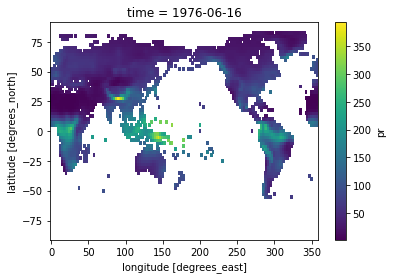

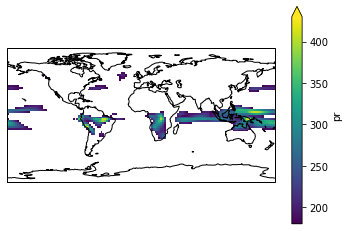

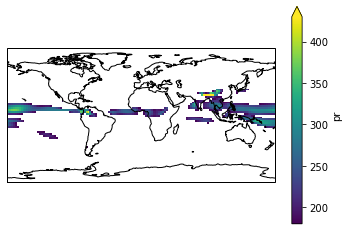

In [6]:
pr_c5_hist['mean'].where(mask_land == 1).pr.plot(); plt.show();
ax = plt.axes(projection=ccrs.PlateCarree());
pr_c5_hist['mean_ndjfm'].pr.plot(ax=ax, vmin=180, extend='max', vmax=430); ax.coastlines(); 
cmap=plt.get_cmap()
cmap.set_under('w')
plt.show();
ax = plt.axes(projection=ccrs.PlateCarree());
pr_c5_hist['mean_mjjas'].pr.plot(ax=ax, vmin=180, extend='max', vmax=430);
ax.coastlines();
plt.show();

In [7]:
# Create weights 
da = pr_c5_hist['ds'].pr
weights = np.cos(np.deg2rad(da.lat))
weights.name = "weights"

In [8]:
u_ndjfm_hist = ua_c6_hist['mean_ndjfm'].ua.isel(plev=0)
v_ndjfm_hist = va_c6_hist['mean_ndjfm'].va.isel(plev=0)
u_mjjas_hist = ua_c6_hist['mean_mjjas'].ua.isel(plev=0)
v_mjjas_hist = va_c6_hist['mean_mjjas'].va.isel(plev=0)

u_ndjfm_126_close = ua_c6_126_close['mean_ndjfm'].ua.isel(plev=0)
v_ndjfm_126_close = va_c6_126_close['mean_ndjfm'].va.isel(plev=0)
u_mjjas_126_close = ua_c6_126_close['mean_mjjas'].ua.isel(plev=0)
v_mjjas_126_close = va_c6_126_close['mean_mjjas'].va.isel(plev=0)

u_ndjfm_126_far = ua_c6_126_far['mean_ndjfm'].ua.isel(plev=0)
v_ndjfm_126_far = va_c6_126_far['mean_ndjfm'].va.isel(plev=0)
u_mjjas_126_far = ua_c6_126_far['mean_mjjas'].ua.isel(plev=0)
v_mjjas_126_far = va_c6_126_far['mean_mjjas'].va.isel(plev=0)

u_ndjfm_585_close = ua_c6_585_close['mean_ndjfm'].ua.isel(plev=0)
v_ndjfm_585_close = va_c6_585_close['mean_ndjfm'].va.isel(plev=0)
u_mjjas_585_close = ua_c6_585_close['mean_mjjas'].ua.isel(plev=0)
v_mjjas_585_close = va_c6_585_close['mean_mjjas'].va.isel(plev=0)

u_ndjfm_585_far = ua_c6_585_far['mean_ndjfm'].ua.isel(plev=0)
v_ndjfm_585_far = va_c6_585_far['mean_ndjfm'].va.isel(plev=0)
u_mjjas_585_far = ua_c6_585_far['mean_mjjas'].ua.isel(plev=0)
v_mjjas_585_far = va_c6_585_far['mean_mjjas'].va.isel(plev=0)

uvel_ndjfm_hist, lonu = add_cyclic_point(u_ndjfm_hist, coord=u_ndjfm_hist.lon)
vvel_ndjfm_hist, lonv = add_cyclic_point(v_ndjfm_hist, coord=v_ndjfm_hist.lon)
uvel_mjjas_hist, lonu = add_cyclic_point(u_mjjas_hist, coord=u_mjjas_hist.lon)
vvel_mjjas_hist, lonv = add_cyclic_point(v_mjjas_hist, coord=v_mjjas_hist.lon)
field, lon = add_cyclic_point(pr_c5_hist['mean'].pr, 
                              coord=pr_c5_hist['mean'].lon)
lonu = np.where(lonu>=180.,lonu-360.,lonu)

crs_latlon = ccrs.PlateCarree()


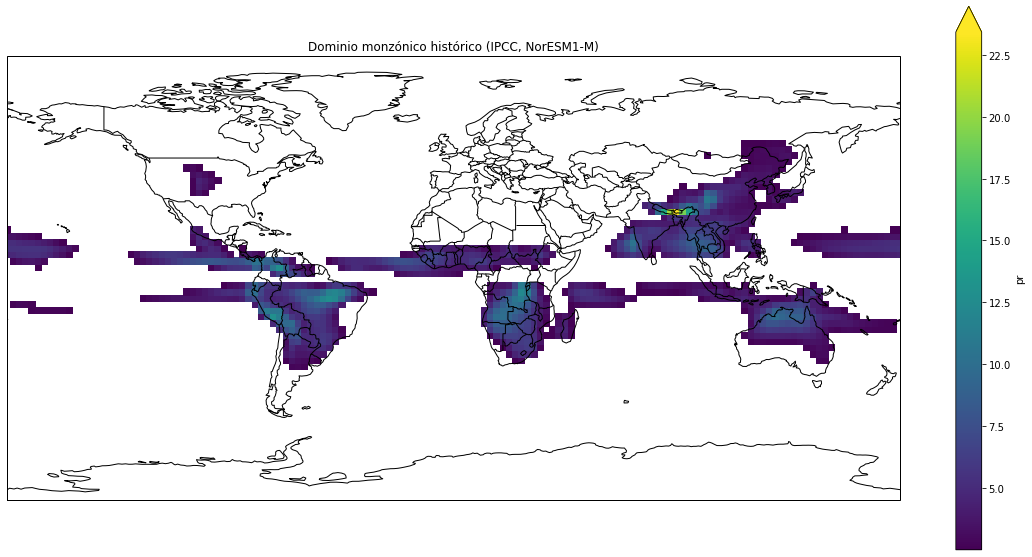

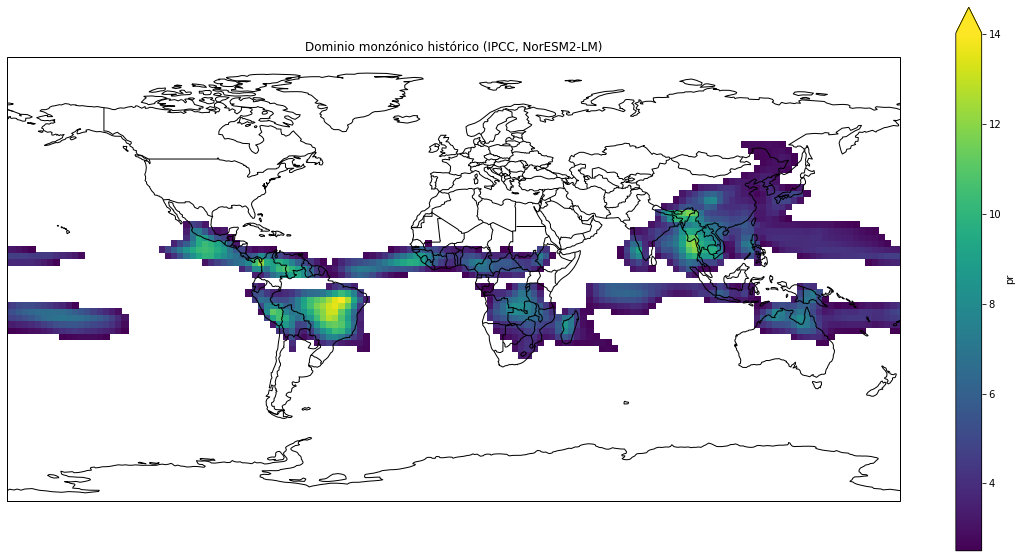

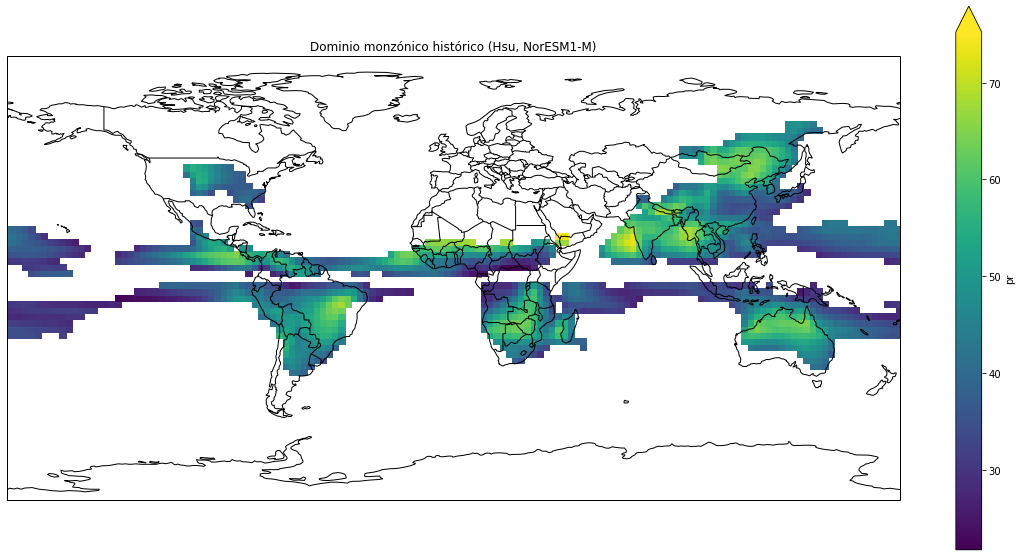

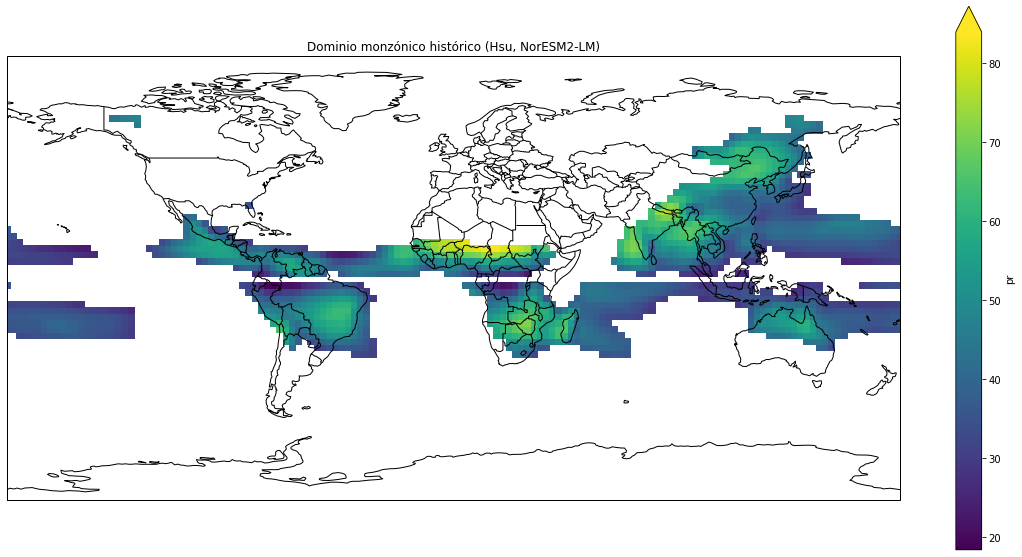

In [9]:
monsoon_land_sh, area_sh_hist = set_monsoon_area(pr_c5_hist['ds'].pr)
monsoon_land_nh, area_nh_hist = set_monsoon_area(pr_c5_hist['ds'].pr, hemisphere='NH')
ploteo_general(monsoon_land_sh.combine_first(monsoon_land_nh))
plt.title('Dominio monzónico histórico (IPCC, NorESM1-M)')
plt.show()

monsoon_land_sh, area_sh_hist = set_monsoon_area(pr_c6_hist['ds'].pr)
monsoon_land_nh, area_nh_hist = set_monsoon_area(pr_c6_hist['ds'].pr, hemisphere='NH')
ploteo_general(monsoon_land_sh.combine_first(monsoon_land_nh))
plt.title('Dominio monzónico histórico (IPCC, NorESM2-LM)')
plt.show()
#print((latlon_domain(area_sh_hist, [230, 330, -60, 25]).where(mask_land == 1) * weights).sum().values )
#ploteo_general(latlon_domain(monsoon_land_sh, [230, 330, -60, 25]).where(mask_land == 1))

#############33
monsoon_hsu_sh_hist, area_hsu_sh_hist = set_monsoon_area(pr_c5_hist['ds'].pr, method='Hsu')
monsoon_hsu_nh_hist, area_hsu_nh_hist = set_monsoon_area(pr_c5_hist['ds'].pr, method='Hsu', hemisphere='NH')
ploteo_general(monsoon_hsu_sh_hist.combine_first(monsoon_hsu_nh_hist))
plt.title('Dominio monzónico histórico (Hsu, NorESM1-M)')
plt.show()

monsoon_hsu_sh_hist, area_hsu_sh_hist = set_monsoon_area(pr_c6_hist['ds'].pr, method='Hsu')
monsoon_hsu_nh_hist, area_hsu_nh_hist = set_monsoon_area(pr_c6_hist['ds'].pr, method='Hsu', hemisphere='NH')
ploteo_general(monsoon_hsu_sh_hist.combine_first(monsoon_hsu_nh_hist))
plt.title('Dominio monzónico histórico (Hsu, NorESM2-LM)')
plt.show()


N° celdas histórico 
1120.1849663548053


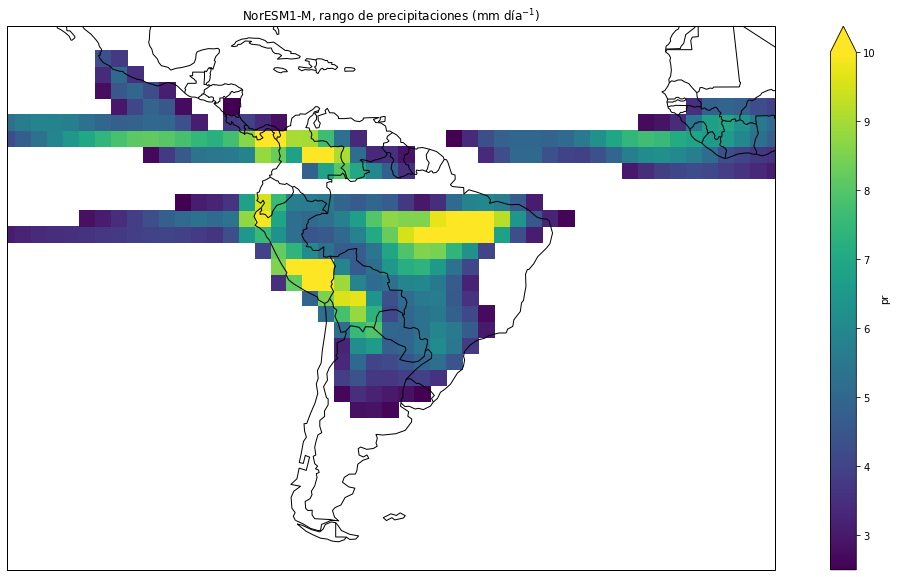

N° celdas histórico 
1120.1849663548053


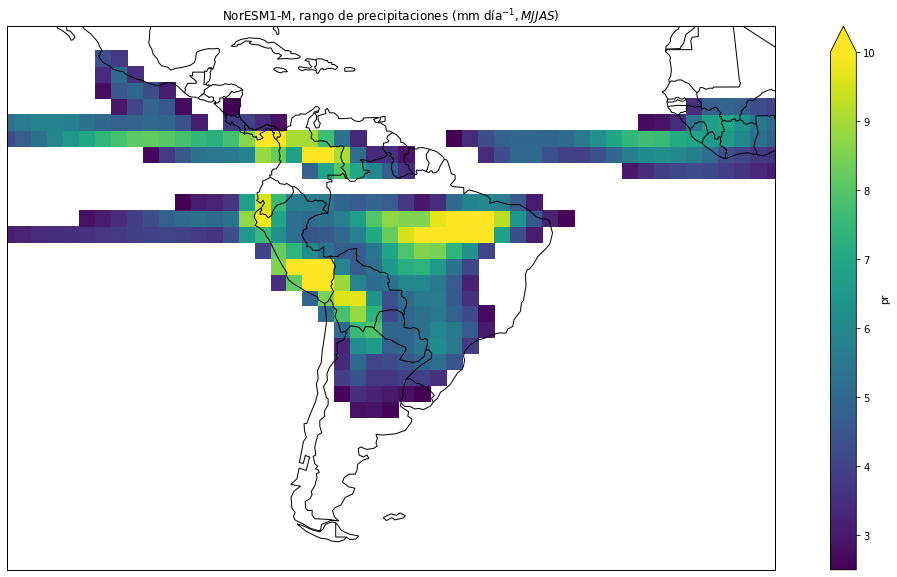

N° celdas RCP 26:
1172.7506928530304


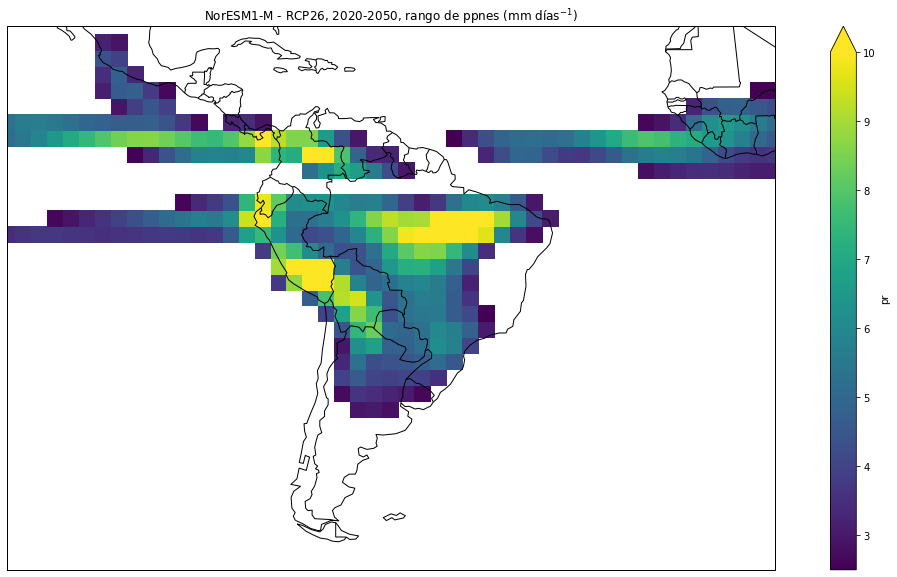

N° celdas RCP 85:
1159.3176359970425


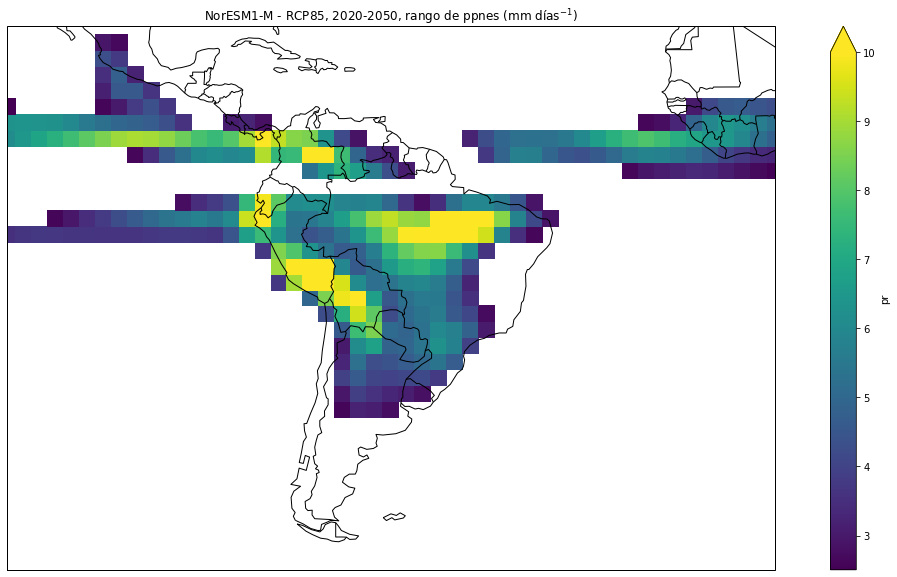

N° celdas RCP 26:
1143.1883729931


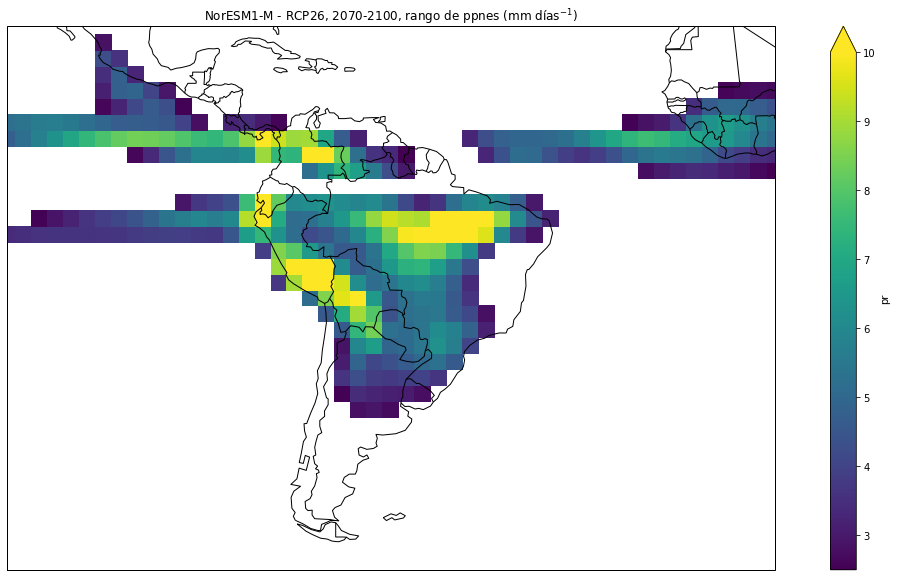

N° celdas RCP 85:
1234.7027791379894


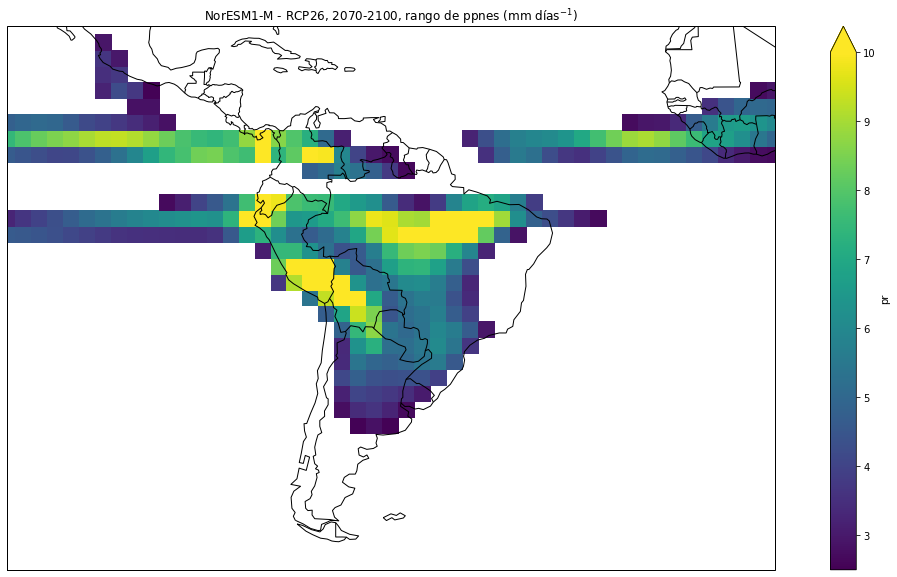

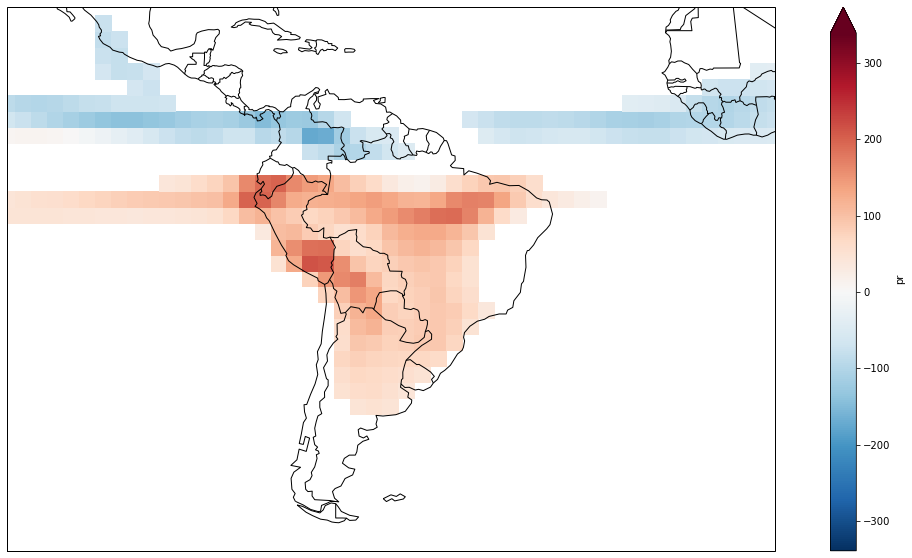

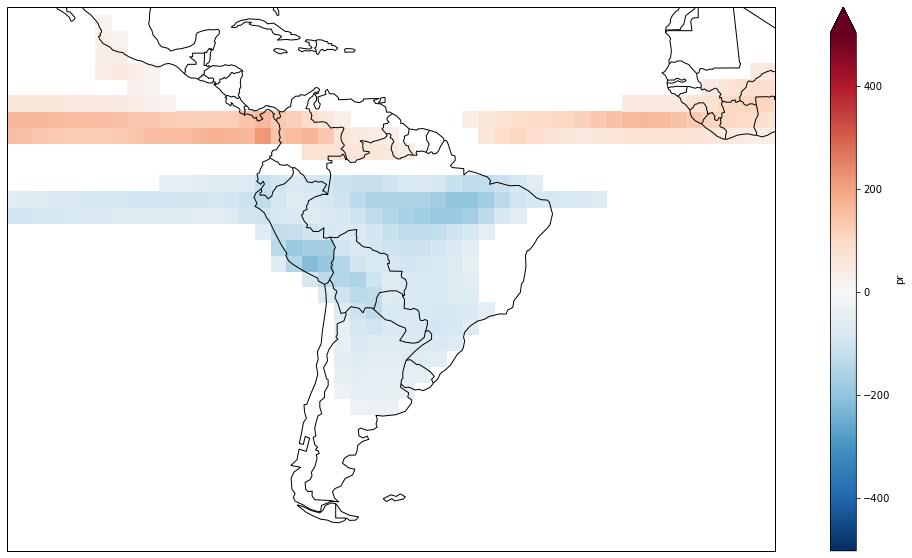

In [10]:


##################################
monsoon_sh_hist, area_sh_hist = set_monsoon_area(pr_c5_hist['ds'].pr) 
monsoon_nh_hist, area_nh_hist = set_monsoon_area(pr_c5_hist['ds'].pr, hemisphere='NH')
ax = ploteo_general(monsoon_sh_hist.combine_first(monsoon_nh_hist), vmax=10,
               title='NorESM1-M, rango de precipitaciones (mm día$^{-1}$)')
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
print('N° celdas histórico ')
print(((area_nh_hist + area_sh_hist) * weights).sum().values)
plt.show()

####
monsoon_sh_hist, area_sh_hist = set_monsoon_area(pr_c5_hist['ds'].pr)
monsoon_nh_hist, area_nh_hist = set_monsoon_area(pr_c5_hist['ds'].pr, hemisphere='NH')
ax = ploteo_general(monsoon_sh_hist.combine_first(monsoon_nh_hist), vmax=10,
               title='NorESM1-M, rango de precipitaciones (mm día$^{-1}, MJJAS$)')
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
print('N° celdas histórico ')
print(((area_nh_hist + area_sh_hist)* weights).sum().values)
plt.show()

####

monsoon_sh_26_close, area_sh_26_close = set_monsoon_area(pr_c5_26_close['ds'].pr)
monsoon_nh_26_close, area_nh_26_close = set_monsoon_area(pr_c5_26_close['ds'].pr, hemisphere='NH')
ax = ploteo_general(monsoon_sh_26_close.combine_first(monsoon_nh_26_close), vmax = 10,
               title='NorESM1-M - RCP26, 2020-2050, rango de ppnes (mm días$^{-1}$)')
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
print('N° celdas RCP 26:')
print(((area_nh_26_close + area_sh_26_close)* weights).sum().values)
plt.show()

#####

monsoon_sh_85_close, area_sh_85_close = set_monsoon_area(pr_c5_85_close['ds'].pr)
monsoon_nh_85_close, area_nh_85_close = set_monsoon_area(pr_c5_85_close['ds'].pr, hemisphere='NH')
ax = ploteo_general(monsoon_sh_85_close.combine_first(monsoon_nh_85_close), vmax = 10,
               title='NorESM1-M - RCP85, 2020-2050, rango de ppnes (mm días$^{-1}$)')
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
print('N° celdas RCP 85:')
print(((area_nh_85_close + area_sh_85_close)* weights).sum().values)
plt.show()

#####

monsoon_sh_26_far, area_sh_26_far = set_monsoon_area(pr_c5_26_far['ds'].pr)
monsoon_nh_26_far, area_nh_26_far = set_monsoon_area(pr_c5_26_far['ds'].pr, hemisphere='NH')
ax = ploteo_general(monsoon_sh_26_far.combine_first(monsoon_nh_26_far), vmax = 10,
               title='NorESM1-M - RCP26, 2070-2100, rango de ppnes (mm días$^{-1}$)')
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
print('N° celdas RCP 26:')
print(((area_nh_26_far + area_sh_26_far)* weights).sum().values)
plt.show()

#####

monsoon_sh_85_far, area_sh_85_far = set_monsoon_area(pr_c5_85_far['ds'].pr)
monsoon_nh_85_far, area_nh_85_far = set_monsoon_area(pr_c5_85_far['ds'].pr, hemisphere='NH')
ax = ploteo_general(monsoon_sh_85_far.combine_first(monsoon_nh_85_far), vmax = 10,
               title='NorESM1-M - RCP26, 2070-2100, rango de ppnes (mm días$^{-1}$)')
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
print('N° celdas RCP 85:')
print(((area_nh_85_far + area_sh_85_far)* weights).sum().values)
plt.show()

##################
ax = ploteo_general(pr_c5_85_far['ds'].pr.where(load_mask(pr_c5_85_far['ds'])[0]).mean(dim='time').where(
                    area_sh_85_far + area_nh_85_far == 1) - pr_c5_26_far['ds'].pr.mean(dim='time'))
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
plt.show()

ax = ploteo_general(pr_c5_85_far['ds'].pr.where(load_mask(pr_c5_85_far['ds'])[1]).mean(dim='time').where(area_sh_85_far + area_nh_85_far == 1) - 
                    pr_c5_26_far['ds'].pr.mean(dim='time'))
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)

N° celdas histórico 
1277.7562685291873


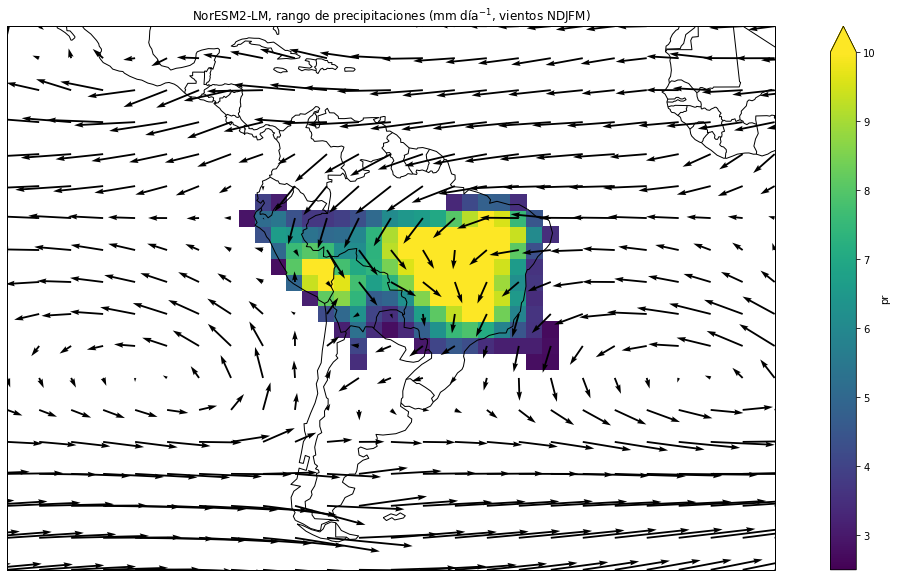

N° celdas histórico 
1277.7562685291873


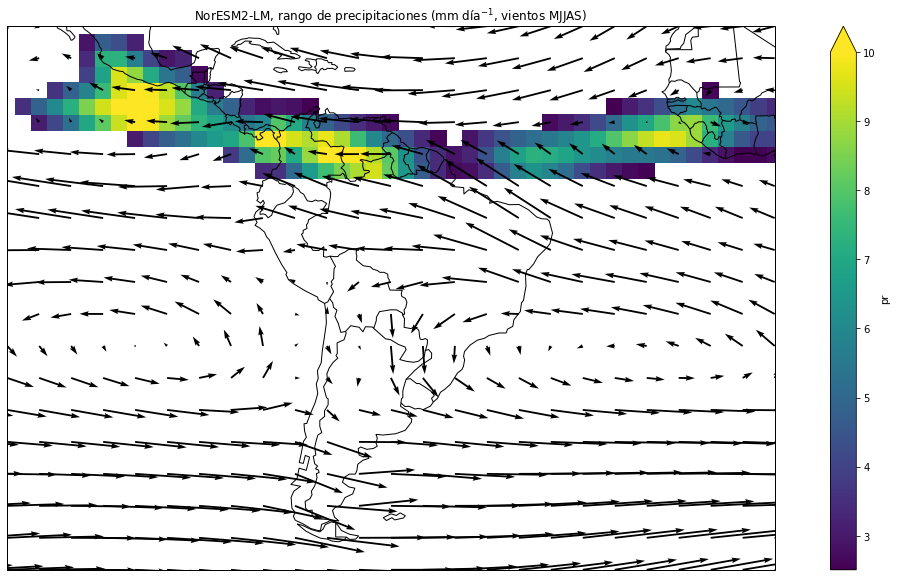

N° celdas SSPS 126:
1253.967821005388


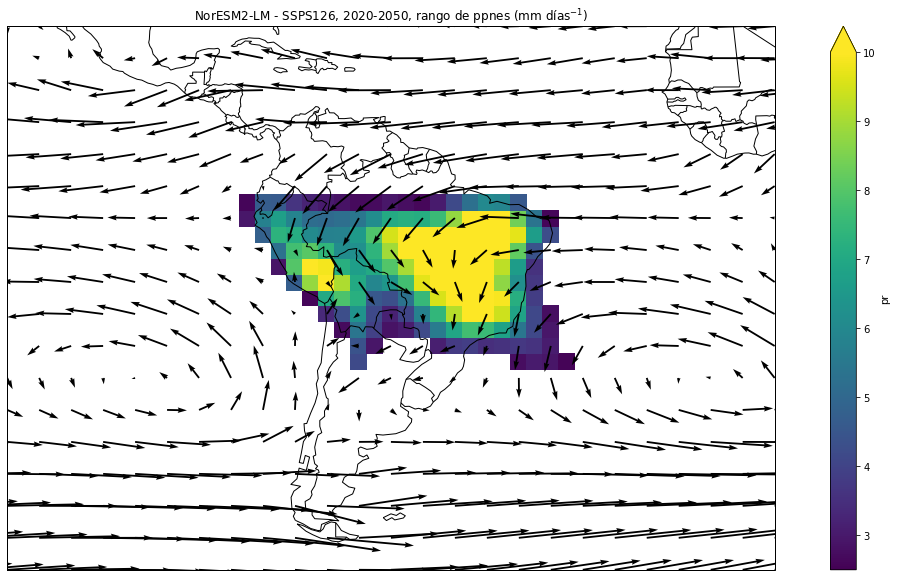

N° celdas SSPS 126:
1234.222093438294


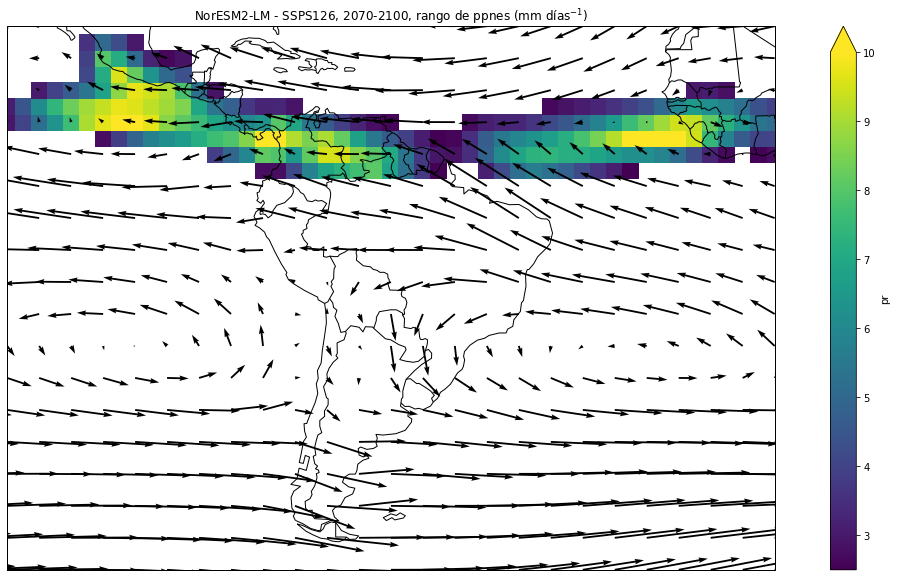

N° celdas SSPS 585:
1240.2830496949737


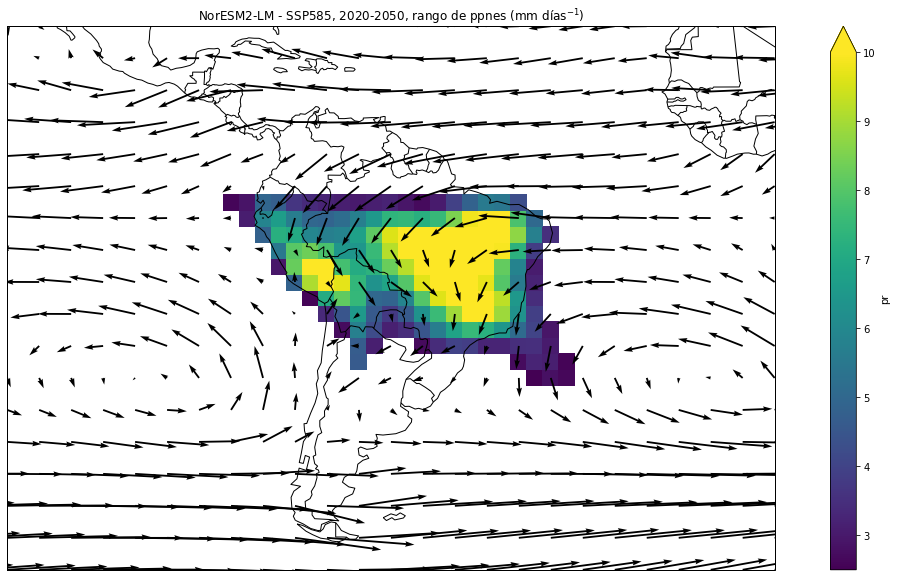

N° celdas SSPS 585:
N° celdas SSPS 585:
1243.2104710322471


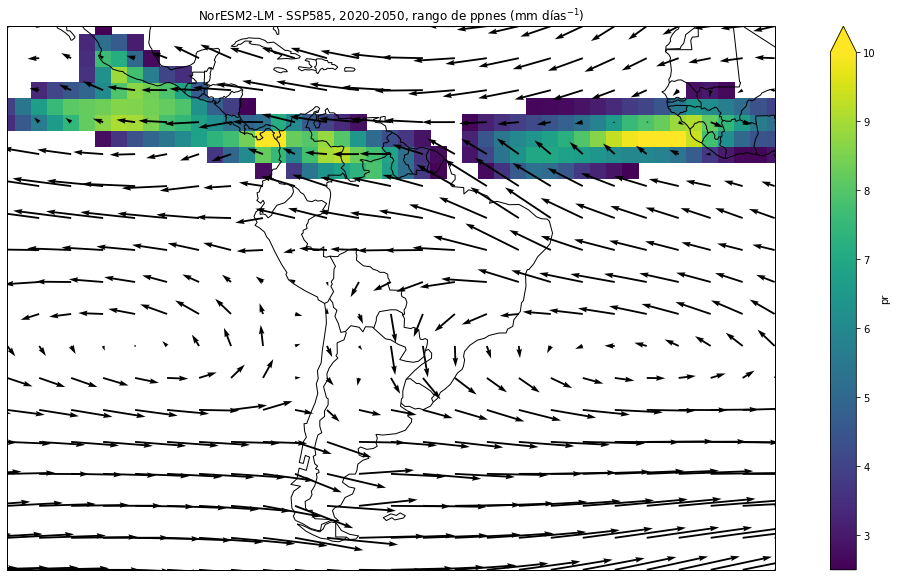

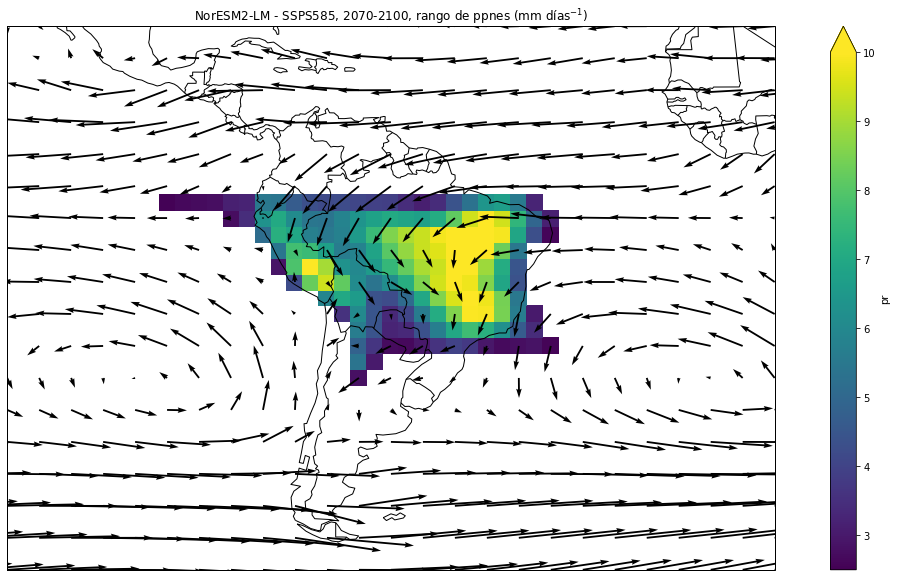

/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


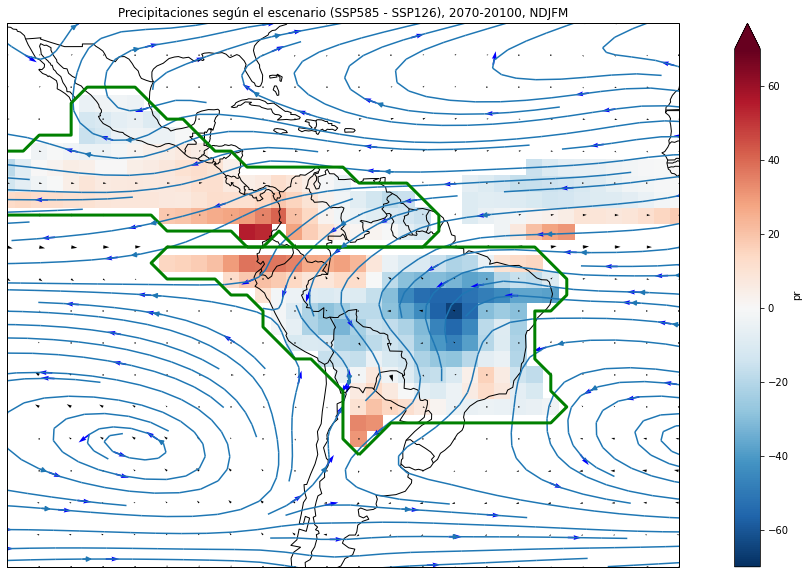

/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


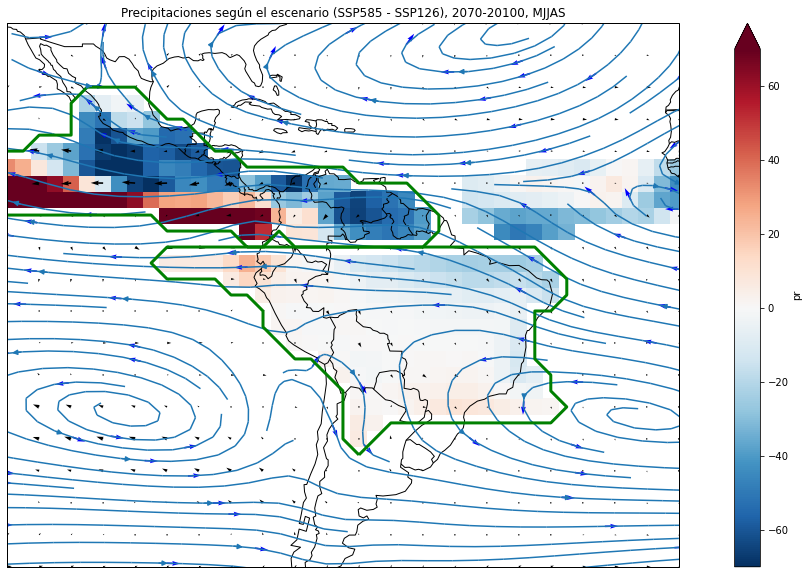

/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


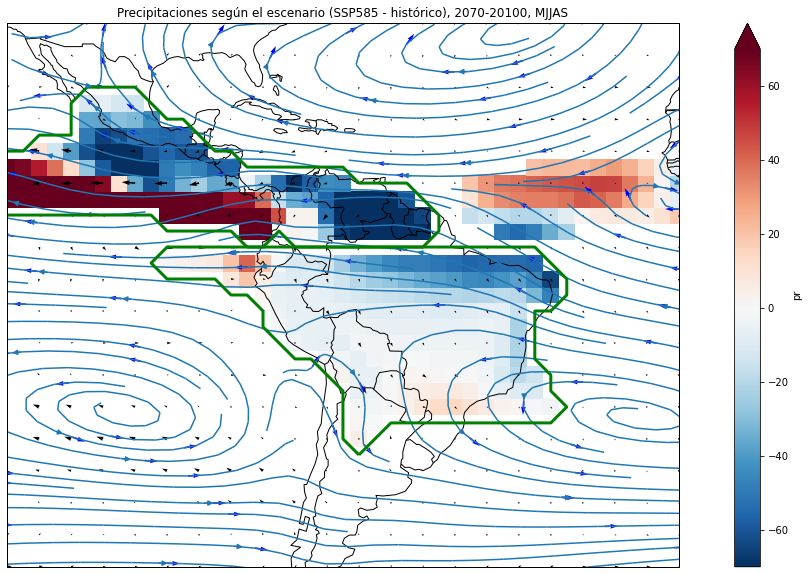

/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


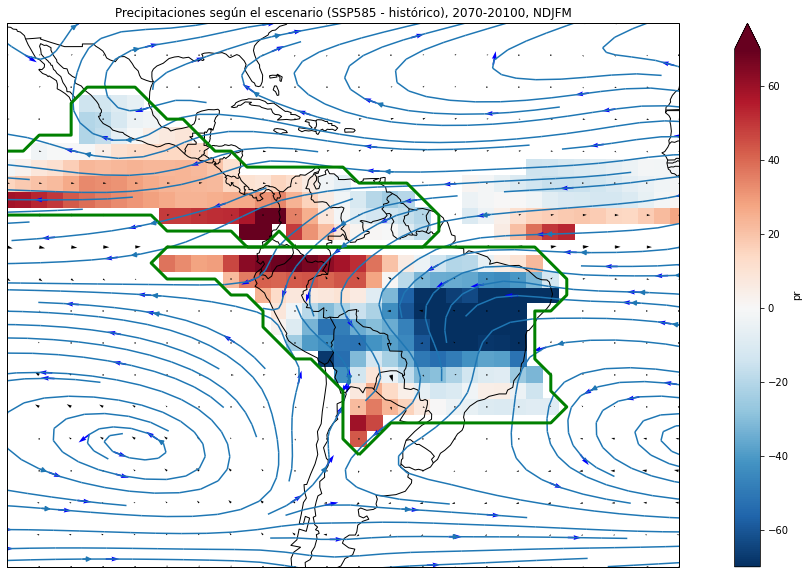

In [22]:
monsoon_sh_hist, area_sh_hist = set_monsoon_area(pr_c6_hist['ds'].pr) 
monsoon_nh_hist, area_nh_hist = set_monsoon_area(pr_c6_hist['ds'].pr, hemisphere='NH')
ax = ploteo_general(monsoon_sh_hist, vmax=10,
               title='NorESM2-LM, rango de precipitaciones (mm día$^{-1}$, vientos NDJFM)')
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
ax.quiver(u_ndjfm_hist.lon[0::2], u_ndjfm_hist.lat[0::2], u_ndjfm_hist[0::2, 0::2],
                                            v_ndjfm_hist[0::2, 0::2], scale=130)
print('N° celdas histórico ')
print(((area_nh_hist + area_sh_hist) * weights).sum().values)
plt.show()

# """"""""""""""""""""""""""""""""""""""""""""""""""
# monsoon_sh_hist, area_sh_hist = set_monsoon_area(pr_c6_hist['ds'].pr) 
# monsoon_nh_hist, area_nh_hist = set_monsoon_area(pr_c6_hist['ds'].pr, hemisphere='NH')
# ax = ploteo_general(monsoon_sh_hist.combine_first(monsoon_nh_hist), vmax=10,
#                title='NorESM2-LM, rango de precipitaciones (mm día$^{-1}$, vientos NDJFM)')
# ax.set_extent([-180, 20, -60, 70], crs=crs_latlon)
# ax.streamplot(lonu, u_ndjfm.lat, uvel_ndjfm, vvel_ndjfm, color='b')
# print('N° celdas histórico ')
# print((area_nh_hist + area_sh_hist).sum().values)
# plt.show()
# """"""""""""""""""""""""""""""""""""""""""""""""""
monsoon_sh_hist, area_sh_hist = set_monsoon_area(pr_c6_hist['ds'].pr)
monsoon_nh_hist, area_nh_hist = set_monsoon_area(pr_c6_hist['ds'].pr, hemisphere='NH')
ax = ploteo_general(monsoon_nh_hist, vmax=10,
               title='NorESM2-LM, rango de precipitaciones (mm día$^{-1}$, vientos MJJAS)')
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
ax.quiver(u_mjjas_hist.lon[0::2], u_mjjas_hist.lat[0::2], u_mjjas_hist[0::2, 0::2],
                                            v_mjjas_hist[0::2, 0::2], scale=130)
print('N° celdas histórico ')
print(((area_nh_hist + area_sh_hist) * weights).sum().values)
plt.show()

# """"""""""""""""""""""""""""""""""""""""""""""""""
# monsoon_sh_hist, area_sh_hist = set_monsoon_area(pr_c6_hist['ds'].pr)
# monsoon_nh_hist, area_nh_hist = set_monsoon_area(pr_c6_hist['ds'].pr, hemisphere='NH')
# ax = ploteo_general(monsoon_sh_hist.combine_first(monsoon_nh_hist), vmax=10,
#                title='NorESM2-LM, rango de precipitaciones (mm día$^{-1}$, vientos MJJAS)')
# ax.set_extent([-180, 0, -60, 70], crs=crs_latlon)
# ax.streamplot(lonu, u_mjjas.lat, uvel_mjjas, vvel_mjjas, color='b', density=1)
# #ax.streamplot(lonu, u.lat, uvel_mjjas.mean(axis=0), vvel_mjjas.mean(axis=0), color='r')
# print('N° celdas histórico ')
# print((area_nh_hist + area_sh_hist).sum().values)
# plt.show()
# 
# """"""""""""""""""""""""""""""""""""""""""""""""""

monsoon_sh_126_close, area_sh_126_close = set_monsoon_area(pr_c6_126_close['ds'].pr)
monsoon_nh_126_close, area_nh_126_close = set_monsoon_area(pr_c6_126_close['ds'].pr, hemisphere='NH')
ax = ploteo_general(monsoon_sh_126_close, vmax = 10,
                    title='NorESM2-LM - SSPS126, 2020-2050, rango de ppnes (mm días$^{-1}$)')
ax.quiver(u_ndjfm_126_close.lon[0::2], u_ndjfm_126_close.lat[0::2],
          u_ndjfm_126_close[0::2, 0::2], v_ndjfm_126_close[0::2, 0::2], scale=130)
print('N° celdas SSPS 126:')
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
print(((area_nh_126_close + area_sh_126_close) * weights).sum().values)
plt.show()

#####

#####

monsoon_sh_126_far, area_sh_126_far = set_monsoon_area(pr_c6_126_far['ds'].pr)
monsoon_nh_126_far, area_nh_126_far = set_monsoon_area(pr_c6_126_far['ds'].pr, hemisphere='NH')
ax = ploteo_general(monsoon_nh_126_far, vmax = 10,
                    title='NorESM2-LM - SSPS126, 2070-2100, rango de ppnes (mm días$^{-1}$)')
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
ax.quiver(u_mjjas_126_close.lon[0::2], u_mjjas_126_close.lat[0::2],
          u_mjjas_126_close[0::2, 0::2], v_mjjas_126_close[0::2, 0::2], scale=130)
print('N° celdas SSPS 126:')
print(((area_nh_126_far + area_sh_126_far) * weights).sum().values)
plt.show()

#####

monsoon_sh_585_close, area_sh_585_close = set_monsoon_area(pr_c6_585_close['ds'].pr)
monsoon_nh_585_close, area_nh_585_close = set_monsoon_area(pr_c6_585_close['ds'].pr, hemisphere='NH')
ax = ploteo_general(monsoon_sh_585_close, vmax = 10,
                    title='NorESM2-LM - SSP585, 2020-2050, rango de ppnes (mm días$^{-1}$)')
print('N° celdas SSPS 585:')
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
ax.quiver(u_ndjfm_585_close.lon[0::2], u_ndjfm_585_close.lat[0::2],
          u_ndjfm_585_close[0::2, 0::2], v_ndjfm_585_close[0::2, 0::2], scale=130)
print(((area_nh_585_close + area_sh_585_close) * weights).sum().values)
plt.show()
ax = ploteo_general(monsoon_nh_585_close, vmax = 10,
                    title='NorESM2-LM - SSP585, 2020-2050, rango de ppnes (mm días$^{-1}$)')
print('N° celdas SSPS 585:')
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
ax.quiver(u_mjjas_585_close.lon[0::2], u_mjjas_585_close.lat[0::2],
          u_mjjas_585_close[0::2, 0::2], v_mjjas_585_close[0::2, 0::2], scale=130)

#####

#####

monsoon_sh_585_far, area_sh_585_far = set_monsoon_area(pr_c6_585_far['ds'].pr)
monsoon_nh_585_far, area_nh_585_far = set_monsoon_area(pr_c6_585_far['ds'].pr, hemisphere='NH')
ax = ploteo_general(monsoon_sh_585_far, vmax = 10,
                    title='NorESM2-LM - SSPS585, 2070-2100, rango de ppnes (mm días$^{-1}$)')
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
ax.quiver(u_ndjfm_126_close.lon[0::2],   u_ndjfm_126_close.lat[0::2],
          u_ndjfm_126_close[0::2, 0::2], v_ndjfm_126_close[0::2, 0::2], scale=130)
print('N° celdas SSPS 585:')
print(((area_nh_585_far + area_sh_585_far) * weights).sum().values)
plt.show()


##########

ax = ploteo_general(pr_c6_585_far['mean_ndjfm'].pr.where(area_sh_585_far + area_nh_585_far == 1) - 
                    pr_c6_126_far['mean_ndjfm'].pr, vmin=-70, vmax=70, cmap='RdBu_r',
                    title='Precipitaciones según el escenario (SSP585 - SSP126), 2070-20100, NDJFM')

# ax.quiver(u_ndjfm_585_far.lon[0::2],   u_ndjfm_585_far.lat[0::2],
#           u_mjjas_585_far[0::2, 0::2], v_mjjas_585_far[0::2, 0::2])
          
# ax.quiver(u_mjjas_126_far.lon[0::2],   u_mjjas_126_far.lat[0::2],
#           u_mjjas_126_far[0::2, 0::2], v_mjjas_126_far[0::2, 0::2], color='g', scale=130)

ax.quiver(u_ndjfm_585_far.lon[0::2],    u_ndjfm_585_far.lat[0::2],
          u_ndjfm_585_far[0::2, 0::2] - u_ndjfm_126_far[0::2, 0::2],
          v_ndjfm_585_far[0::2, 0::2] - v_ndjfm_126_far[0::2, 0::2], color='k', scale=130)
sp = ax.streamplot(transform_lon(u_ndjfm_585_far.lon.values), u_ndjfm_585_far.lat.values,
                   u_ndjfm_585_far.values, v_ndjfm_585_far.values, density=3)
plt.contour(u_mjjas_585_far.lon.values, u_mjjas_585_far.lat.values, 
            area_nh_585_far.where(u_mjjas_585_far.lon < 310), levels=0, colors='g', linewidths=3, corner_mask=False)
plt.contour(u_ndjfm_585_far.lon.values, u_ndjfm_585_far.lat.values, 
            area_sh_585_far.where(u_ndjfm_585_far.lon < 360), levels=0, colors='g', linewidths=3, corner_mask=False)
streamQuiver(ax, sp, n=3, color='b')
ax.set_extent([-120, -15, -50, 35], crs=crs_latlon)
plt.show()

##################################################################################
#        
#        ax = ploteo_general(pr_c6_585_far['mean'].pr.where(area_sh_585_far + area_nh_585_far == 1) - 
#                           pr_c6_126_far['ds'].pr.mean(dim='time'), 
#                            title='Precipitaciones según el escenario (SSP585 - SSP126), 2070-20100, General')

#        #ax.quiver(u_mjjas_585_far.lon[0::2],   u_mjjas_585_far.lat[0::2],
#        #          u_mjjas_585_far[0::2, 0::2], v_mjjas_585_far[0::2, 0::2], color='y', scale=130)#
#        
#        plt.show()
#        
#        
ax = ploteo_general(pr_c6_585_far['mean_mjjas'].pr.where(area_sh_585_far + area_nh_585_far == 1) - 
                    pr_c6_126_far['mean_mjjas'].pr, vmin=-70, vmax=70, cmap="RdBu_r",
                    title='Precipitaciones según el escenario (SSP585 - SSP126), 2070-20100, MJJAS')

# ax.quiver(u_ndjfm_585_far.lon[0::2],   u_ndjfm_585_far.lat[0::2],
#           u_mjjas_585_far[0::2, 0::2], v_mjjas_585_far[0::2, 0::2])
          
# ax.quiver(u_mjjas_126_far.lon[0::2],   u_mjjas_126_far.lat[0::2],
#           u_mjjas_126_far[0::2, 0::2], v_mjjas_126_far[0::2, 0::2], color='g', scale=130)

ax.quiver(u_mjjas_585_far.lon[0::2],    u_mjjas_585_far.lat[0::2],
          u_mjjas_585_far[0::2, 0::2] - u_mjjas_126_far[0::2, 0::2],
          v_mjjas_585_far[0::2, 0::2] - v_mjjas_126_far[0::2, 0::2], color='k', scale=130)
sp = ax.streamplot(transform_lon(u_mjjas_585_far.lon.values), u_mjjas_585_far.lat.values,
                   u_mjjas_585_far.values, v_mjjas_585_far.values, density=3)
plt.contour(u_mjjas_585_far.lon.values, u_mjjas_585_far.lat.values, 
            area_nh_585_far.where(u_mjjas_585_far.lon < 310), levels=0, colors='g', linewidths=3)
plt.contour(u_ndjfm_585_far.lon.values, u_ndjfm_585_far.lat.values, 
            area_sh_585_far, levels=0, colors='g', linewidths=3)
streamQuiver(ax, sp, n=3, color='b')
ax.set_extent([-120, -15, -50, 35], crs=crs_latlon)
plt.show()

############################################
ax = ploteo_general(pr_c6_585_far['mean_mjjas'].pr.where(area_sh_585_far + area_nh_585_far == 1) - 
                    pr_c6_hist['mean_mjjas'].pr, vmin=-70, vmax=70, cmap="RdBu_r",
                    title='Precipitaciones según el escenario (SSP585 - histórico), 2070-20100, MJJAS')

# ax.quiver(u_ndjfm_585_far.lon[0::2],   u_ndjfm_585_far.lat[0::2],
#           u_mjjas_585_far[0::2, 0::2], v_mjjas_585_far[0::2, 0::2])
          
# ax.quiver(u_mjjas_126_far.lon[0::2],   u_mjjas_126_far.lat[0::2],
#           u_mjjas_126_far[0::2, 0::2], v_mjjas_126_far[0::2, 0::2], color='g', scale=130)

ax.quiver(u_mjjas_585_far.lon[0::2],    u_mjjas_585_far.lat[0::2],
          u_mjjas_585_far[0::2, 0::2] - u_mjjas_126_far[0::2, 0::2],
          v_mjjas_585_far[0::2, 0::2] - v_mjjas_126_far[0::2, 0::2], color='k', scale=130)
sp = ax.streamplot(transform_lon(u_mjjas_585_far.lon.values), u_mjjas_585_far.lat.values,
                   u_mjjas_585_far.values, v_mjjas_585_far.values, density=3)
plt.contour(u_mjjas_585_far.lon.values, u_mjjas_585_far.lat.values, 
            area_nh_585_far.where(u_mjjas_585_far.lon < 310), levels=0, colors='g', linewidths=3)
plt.contour(u_ndjfm_585_far.lon.values, u_ndjfm_585_far.lat.values, 
            area_sh_585_far, levels=0, colors='g', linewidths=3)
streamQuiver(ax, sp, n=3, color='b')
ax.set_extent([-120, -15, -50, 35], crs=crs_latlon)
plt.show()

############################################
ax = ploteo_general(pr_c6_585_far['mean_ndjfm'].pr.where(area_sh_585_far + area_nh_585_far == 1) - 
                    pr_c6_hist['mean_ndjfm'].pr, vmin=-70, vmax=70, cmap="RdBu_r",
                    title='Precipitaciones según el escenario (SSP585 - histórico), 2070-20100, NDJFM')

# ax.quiver(u_ndjfm_585_far.lon[0::2],   u_ndjfm_585_far.lat[0::2],
#           u_mjjas_585_far[0::2, 0::2], v_mjjas_585_far[0::2, 0::2])
          
# ax.quiver(u_mjjas_126_far.lon[0::2],   u_mjjas_126_far.lat[0::2],
#           u_mjjas_126_far[0::2, 0::2], v_mjjas_126_far[0::2, 0::2], color='g', scale=130)

ax.quiver(u_ndjfm_585_far.lon[0::2],    u_ndjfm_585_far.lat[0::2],
          u_ndjfm_585_far[0::2, 0::2] - u_ndjfm_126_far[0::2, 0::2],
          v_ndjfm_585_far[0::2, 0::2] - v_ndjfm_126_far[0::2, 0::2], color='k', scale=130)
sp = ax.streamplot(transform_lon(u_ndjfm_585_far.lon.values), u_ndjfm_585_far.lat.values,
                   u_ndjfm_585_far.values, v_ndjfm_585_far.values, density=3)
plt.contour(u_ndjfm_585_far.lon.values, u_ndjfm_585_far.lat.values, 
            area_nh_585_far.where(u_ndjfm_585_far.lon < 310), levels=0, colors='g', linewidths=3)
plt.contour(u_ndjfm_585_far.lon.values, u_ndjfm_585_far.lat.values, 
            area_sh_585_far, levels=0, colors='g', linewidths=3)
streamQuiver(ax, sp, n=3, color='b')
ax.set_extent([-120, -15, -50, 35], crs=crs_latlon)
plt.show()

N° celdas histórico 
1347


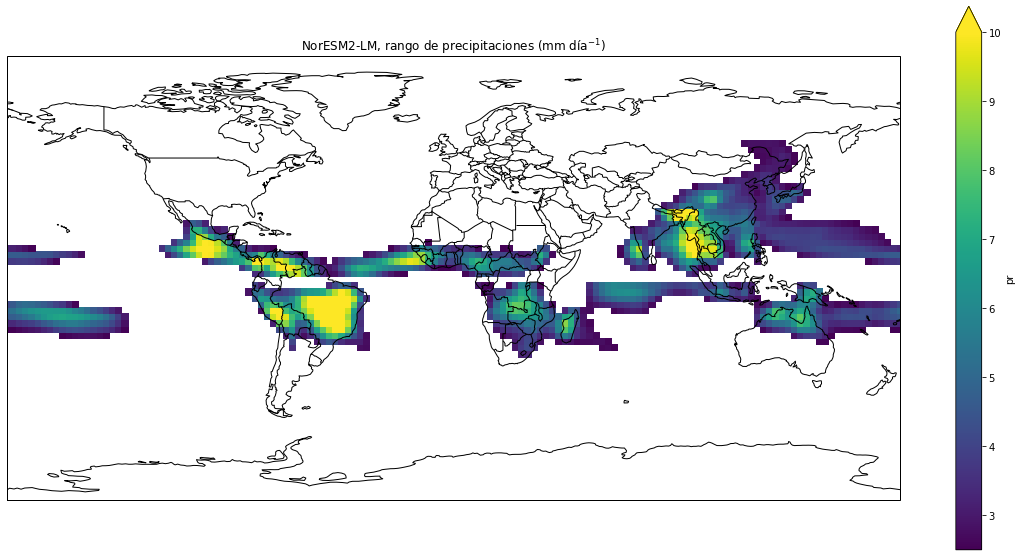

N° celdas SSPS 126:
1324


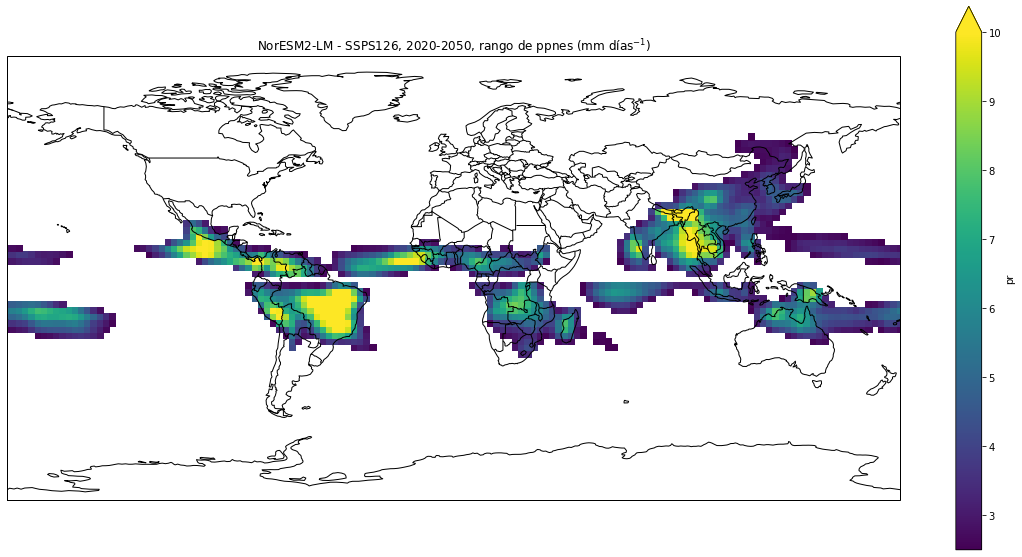

N° celdas SSPS 126:
1306


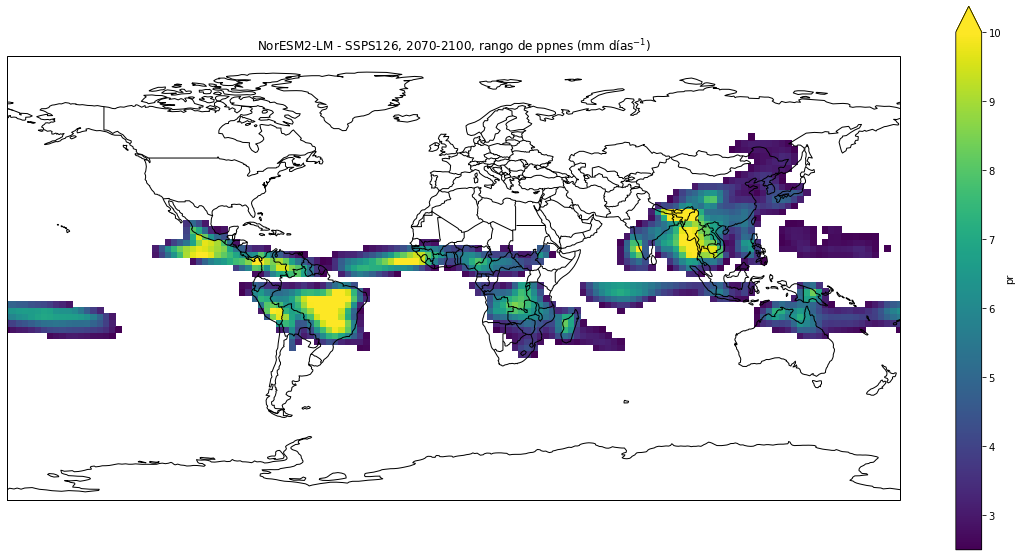

In [12]:
monsoon_sh_hist, area_sh_hist = set_monsoon_area(pr_c6_hist['ds'].pr)
monsoon_nh_hist, area_nh_hist = set_monsoon_area(pr_c6_hist['ds'].pr, hemisphere='NH')
ax = ploteo_general(monsoon_sh_hist.combine_first(monsoon_nh_hist), vmax=10,
                             title='NorESM2-LM, rango de precipitaciones (mm día$^{-1}$)')
print('N° celdas histórico ')
print((area_nh_hist + area_sh_hist).sum().values)
plt.show()

####

monsoon_sh_126_close, area_sh_126_close = set_monsoon_area(pr_c6_126_close['ds'].pr)
monsoon_nh_126_close, area_nh_126_close = set_monsoon_area(pr_c6_126_close['ds'].pr, hemisphere='NH')
ploteo_general(monsoon_sh_126_close.combine_first(monsoon_nh_126_close), vmax = 10,
               title='NorESM2-LM - SSPS126, 2020-2050, rango de ppnes (mm días$^{-1}$)')
print('N° celdas SSPS 126:')
print((area_nh_126_close + area_sh_126_close).sum().values)
plt.show()

#####


#####

monsoon_sh_126_far, area_sh_126_far = set_monsoon_area(pr_c6_126_far['ds'].pr)
monsoon_nh_126_far, area_nh_126_far = set_monsoon_area(pr_c6_126_far['ds'].pr, hemisphere='NH')
ploteo_general(monsoon_sh_126_far.combine_first(monsoon_nh_126_far), vmax = 10,
               title='NorESM2-LM - SSPS126, 2070-2100, rango de ppnes (mm días$^{-1}$)')
print('N° celdas SSPS 126:')
print((area_nh_126_far + area_sh_126_far).sum().values)
plt.show()

#####


In [13]:
# ########### Con rolling average
# average_c5_hist =  pr_c5_hist.pr.mean(dim='ensemble').rolling(time=5)
# average_c5_hist = average_c5_hist.reduce(np.std)
# plt.figure(figsize=(20,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# difference_NH = ((average_c5_hist.where(average_c5_hist.time.dt.month == 7)/153).mean(dim='time') - (
#                  (average_c5_hist.where(average_c5_hist.time.dt.month == 1)/151).mean(dim='time')))
# difference_NH.plot(axes = ax, vmin=1, vmax=3)
# ax.coastlines()
# ax.add_feature(cfeature.BORDERS)
# 

<xarray.DataArray 'time' (time: 360)>
array([cftime.DatetimeNoLeap(1976-01-16 12:00:00),
       cftime.DatetimeNoLeap(1976-02-15 00:00:00),
       cftime.DatetimeNoLeap(1976-03-16 12:00:00), ...,
       cftime.DatetimeNoLeap(2005-10-16 12:00:00),
       cftime.DatetimeNoLeap(2005-11-16 00:00:00),
       cftime.DatetimeNoLeap(2005-12-16 12:00:00)], dtype=object)
Coordinates:
  * time     (time) object 1976-01-16 12:00:00 ... 2005-12-16 12:00:00
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T


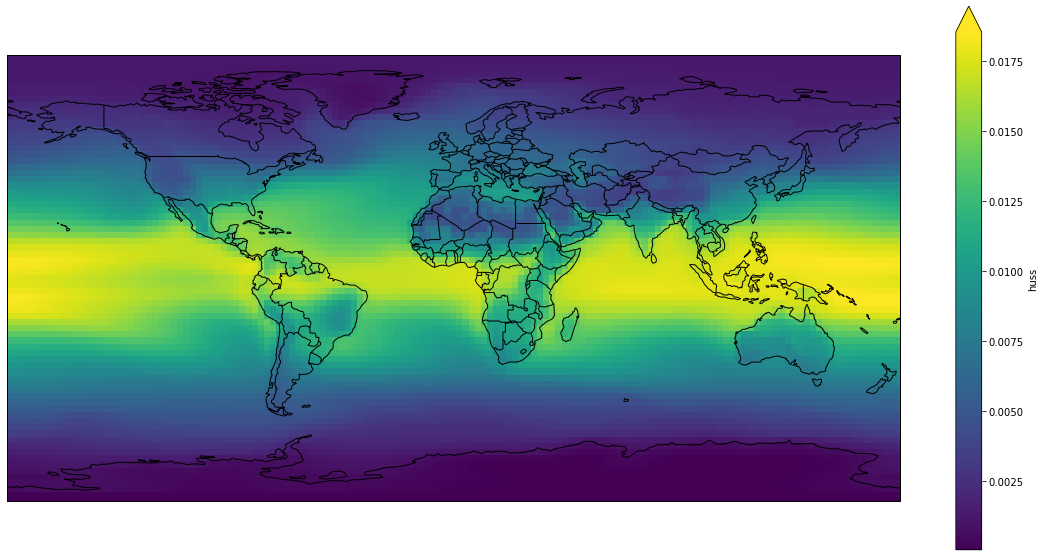

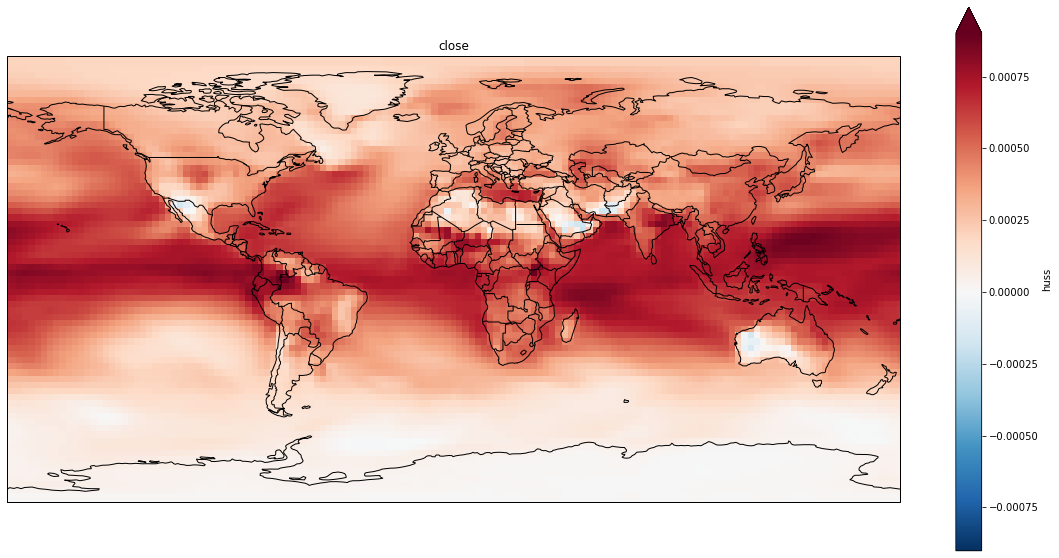

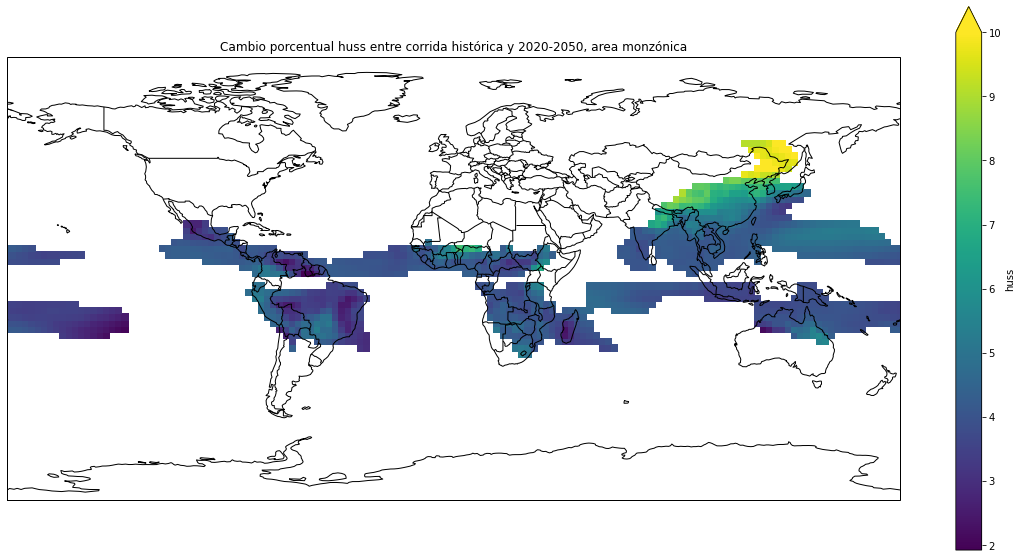

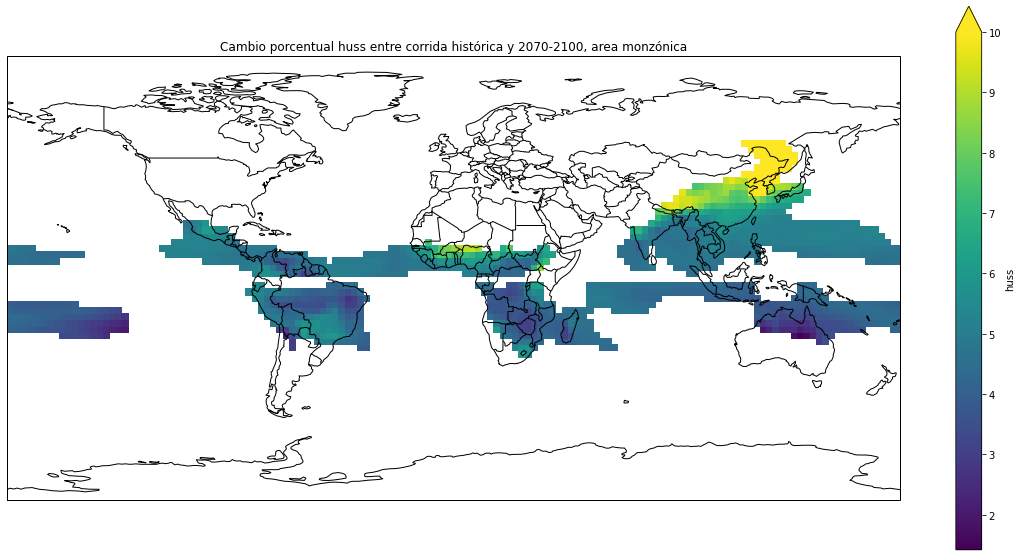

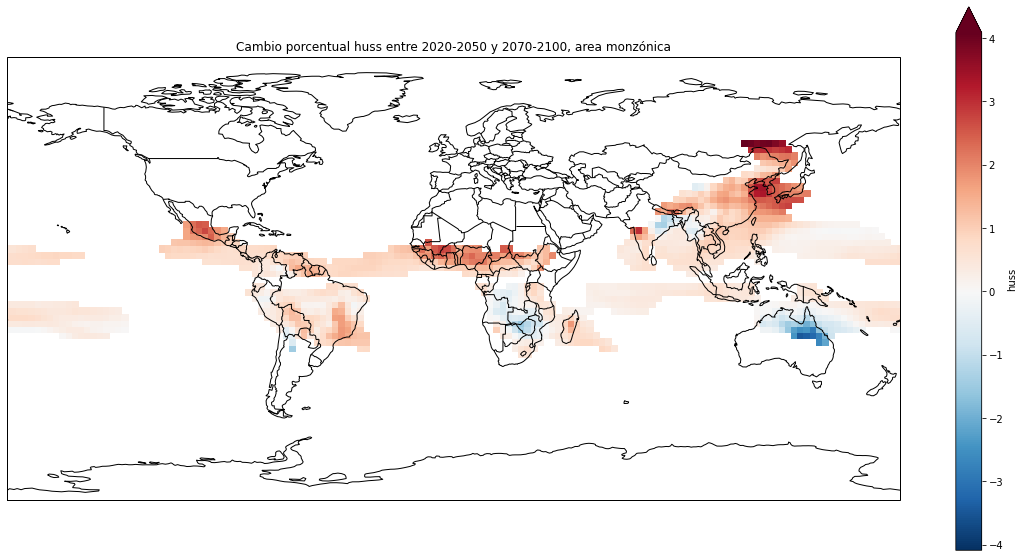

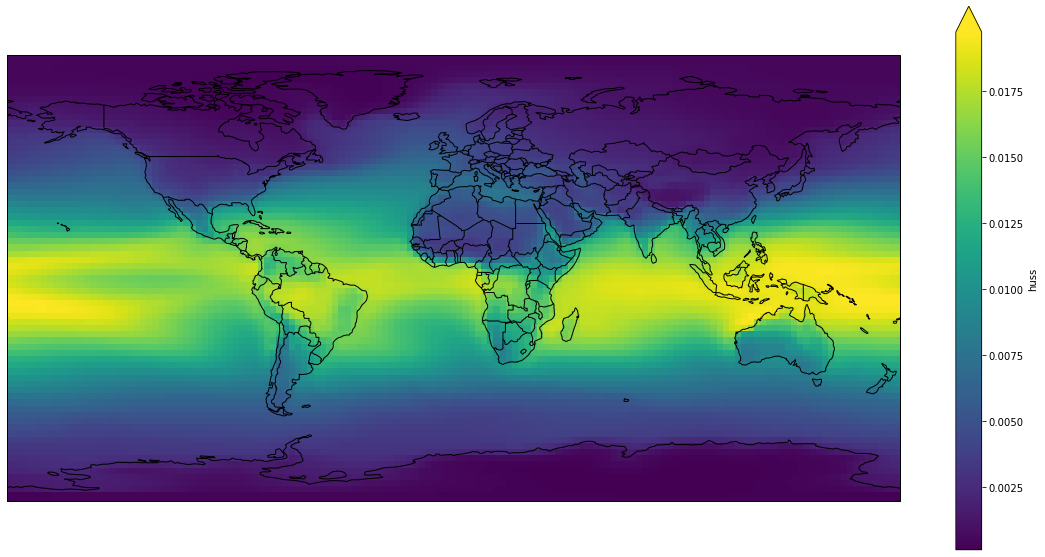

In [14]:
########### Comparando humedad del suelo
print(h_c5_hist['ds'].time)
h5_hist = h_c5_hist['mean'].huss
dq_dx = (h_c5_hist['mean'].huss * 2501000).differentiate(coord='lon')
dq_dy = (h_c5_hist['mean'].huss * 2501000).differentiate(coord='lat')
ax = ploteo_general(h5_hist);
#ax.quiver(h_c5_hist['mean'].lon, h_c5_hist['mean'].lat, dq_dx, dq_dy)
plt.show()
ploteo_general(h_c5_26_close['mean'].huss - h5_hist, title='close');
plt.show()
ploteo_general(200 * (h_c5_26_close['mean'].huss.where((area_sh_hist + area_nh_hist) == 1) -
                      h5_hist.where(area_nh_hist + area_sh_hist == 1))/
               (h_c5_26_close['mean'].huss + h5_hist), vmax=10,
              title='Cambio porcentual huss entre corrida histórica y 2020-2050, area monzónica')
plt.show()
ploteo_general(200 * (h_c5_26_far['mean'].huss.where((area_sh_hist + area_nh_hist) == 1) -
                      h5_hist.where(area_nh_hist + area_sh_hist == 1))/
               (h_c5_26_far['mean'].huss + h5_hist), vmax=10,
              title='Cambio porcentual huss entre corrida histórica y 2070-2100, area monzónica')
plt.show()
ploteo_general(200 * (h_c5_26_far['mean'].huss.where((area_sh_hist + area_nh_hist) == 1) -
                      h_c5_26_close['mean'].huss.where(area_nh_hist + area_sh_hist == 1))/
               (h_c5_26_far['mean'].huss + h_c5_26_close['mean'].huss),
              title='Cambio porcentual huss entre 2020-2050 y 2070-2100, area monzónica')
plt.show()

ploteo_general(h_c6_hist['mean_ndjfm'].huss)

0.09037280021546859


/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


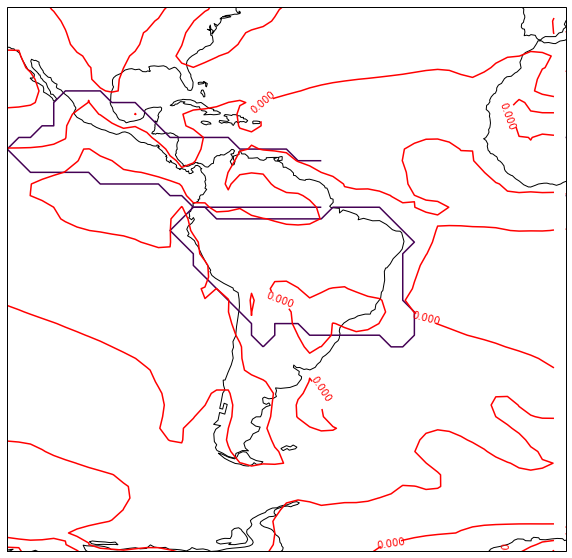

In [15]:
#plt.show();
dT_dx = t_c6_hist['mean_ndjfm'].tas.differentiate(coord='lon')
dT_dy = t_c6_hist['mean_ndjfm'].tas.differentiate(coord='lat')

adv_h = -(u_ndjfm_hist * (dT_dx * 1005 + dq_dx)+ v_ndjfm_hist * (dT_dy * 1005 + dq_dy)) / (weights * 111000)
print(adv_h.values[10,20])
plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-120, 0, -60, 25])
area_sh_hist.plot.contour(levels=[0])
area_nh_hist.where(area_sh_hist.lon<310).plot.contour(levels=[0])
cmap = plt.get_cmap()
cmap.set_under('w')
ploteo = adv_h.plot.contour(ax=ax, vmax=30, vmin=-30, colors='r')
plt.clabel(ploteo, inline=2, fontsize=10)
ax.coastlines()
plt.title('')
plt.show()


1005 meter ** 2 / kelvin / second ** 2
2501000.0 meter ** 2 / second ** 2
joule / kilogram / second
joule / kilogram
(73, 144)
(73, 144)


/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/pint/quantity.py:1160: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


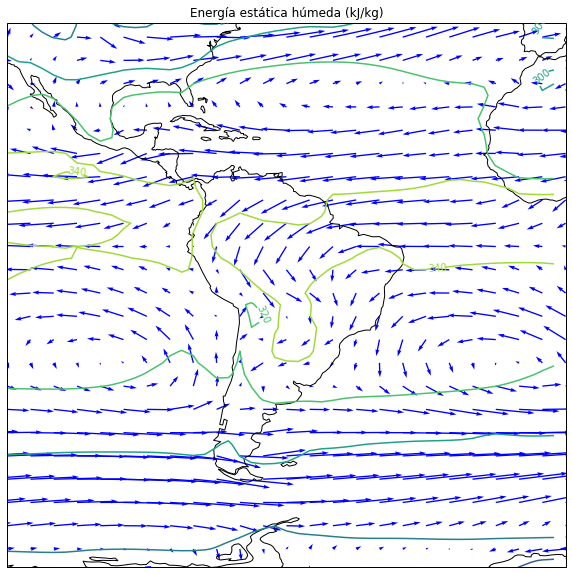

/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/pint/quantity.py:1160: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


joule / kilogram / second
joule / kilogram
(73, 144)
(73, 144)


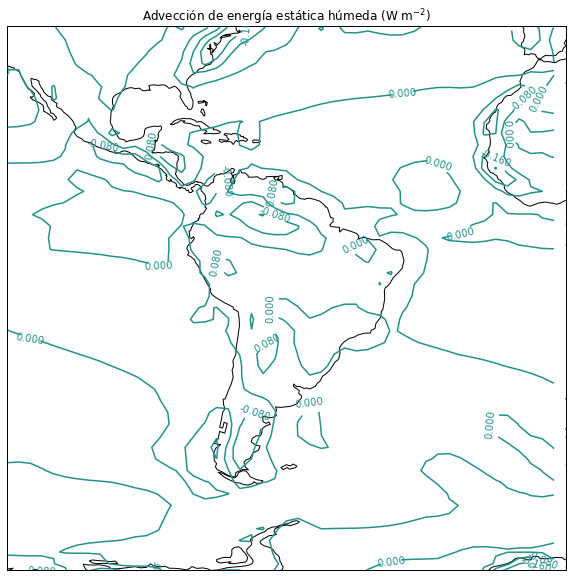

0.009404579032459968 joule / kilogram / second


In [16]:
heights = 2 * np.ones((t_c6_hist['ds'].dims['lat'], t_c6_hist['ds'].dims['lon'])) * units.meter

temperature = t_c6_hist['mean_ndjfm'].tas.values * units.kelvin

humidity = h_c5_hist['mean_ndjfm'].huss.values * units.dimensionless

lon = t_c6_hist['ds'].lon.values * units.degrees
lat = t_c6_hist['ds'].lat.values * units.degrees
u = u_ndjfm_hist.values * units('m/s')
v = v_ndjfm_hist.values * units('m/s')
dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)

print(mpconsts.Cp_d)
print(mpconsts.Lv)

moist_static_energy = mpcalc.moist_static_energy(heights, temperature, humidity).to('J/kg') 


plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
adv = mpcalc.advection(moist_static_energy, [u, v],
                       (dx, dy), dim_order='yx')

print(adv.units)
print(moist_static_energy.units)
print(u.shape)
print(v.shape)
ax.set_extent([-120, 0, -60, 25])
ploteo = plt.contour(lon, lat, moist_static_energy.to('kJ/kg'), transform=ccrs.PlateCarree()) #  vmax=30, vmin=-30,
plt.clabel(ploteo, inline=2, fontsize=10, fmt='%1d')
ax.quiver(u_ndjfm_hist.lon.values[0::2], u_ndjfm_hist.lat.values[0::2],
          u_ndjfm_hist.values[0::2, 0::2], v_ndjfm_hist.values[0::2, 0::2], scale=150, color='b')
ax.coastlines()
plt.title('Energía estática húmeda (kJ/kg)')
plt.show()
############# 
plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
adv = mpcalc.advection(moist_static_energy, [u, v],
                       (dx, dy), dim_order='yx')

plt.title('Advección de energía estática húmeda (W m$^{-2}$)')
print(adv.units)
print(moist_static_energy.units)
print(u.shape)
print(v.shape)
ax.set_extent([-120, 0, -60, 25])
ploteo = plt.contour(lon, lat, adv, vmax=30, vmin=-30, transform=ccrs.PlateCarree())
plt.clabel(ploteo, inline=2, fontsize=10)
ax.coastlines()
plt.show()
print(adv[10,20])

1005 meter ** 2 / kelvin / second ** 2
2501000.0 meter ** 2 / second ** 2
joule / kilogram / second
joule / kilogram
(73, 144)
(73, 144)


/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/pint/quantity.py:1160: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


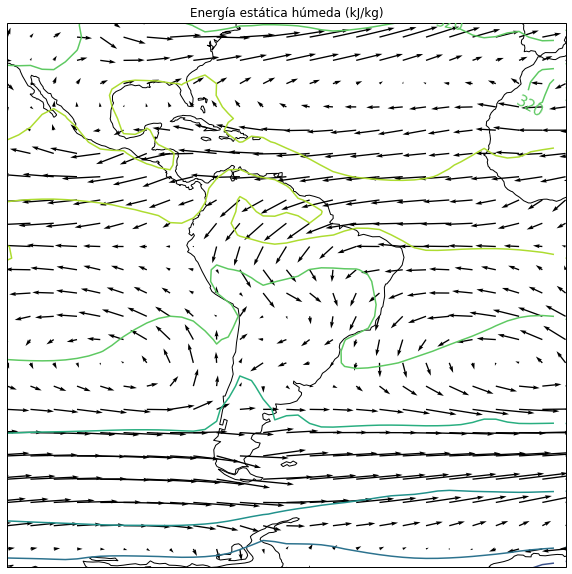

/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/pint/quantity.py:1160: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


joule / kilogram / second
joule / kilogram
(73, 144)
(73, 144)


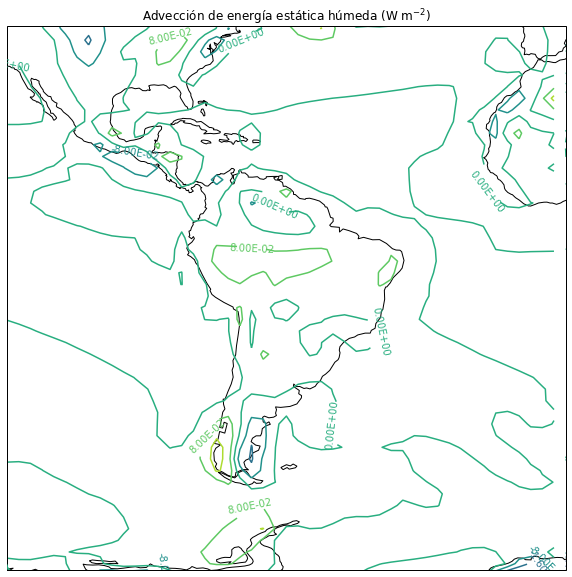

0.0066447490874111115 joule / kilogram / second


In [34]:
heights = 2 * np.ones((t_c6_hist['ds'].dims['lat'], t_c6_hist['ds'].dims['lon'])) * units.meter

temperature = t_c6_hist['mean_mjjas'].tas.values * units.kelvin

humidity = h_c5_hist['mean_mjjas'].huss.values * units.dimensionless

lon = t_c6_hist['ds'].lon.values * units.degrees
lat = t_c6_hist['ds'].lat.values * units.degrees
u = u_ndjfm_hist.values * units('m/s')
v = v_ndjfm_hist.values * units('m/s')
dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)

print(mpconsts.Cp_d)
print(mpconsts.Lv)

moist_static_energy = mpcalc.moist_static_energy(heights, temperature, humidity).to('J/kg') 


plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
adv = mpcalc.advection(moist_static_energy, [u, v],
                       (dx, dy), dim_order='yx')

print(adv.units)
print(moist_static_energy.units)
print(u.shape)
print(v.shape)
ax.set_extent([-120, 0, -60, 25])
ploteo = plt.contour(lon, lat, moist_static_energy.to('kJ/kg'), transform=ccrs.PlateCarree()) #  vmax=30, vmin=-30,
plt.clabel(ploteo, inline=1, fontsize=15, fmt='%1d')
ax.quiver(u_ndjfm_hist.lon.values[0::2], u_ndjfm_hist.lat.values[0::2],
          u_ndjfm_hist.values[0::2, 0::2], v_ndjfm_hist.values[0::2, 0::2], scale=150)
ax.coastlines()
plt.title('Energía estática húmeda (kJ/kg)')
plt.show()
############# 
plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
adv = mpcalc.advection(moist_static_energy, [u, v],
                       (dx, dy), dim_order='yx')

plt.title('Advección de energía estática húmeda (W m$^{-2}$)')
print(adv.units)
print(moist_static_energy.units)
print(u.shape)
print(v.shape)
ax.set_extent([-120, 0, -60, 25])
ploteo = plt.contour(lon, lat, adv, transform=ccrs.PlateCarree())
plt.clabel(ploteo, inline=2, fontsize=10, fmt='%.2E')
ax.coastlines()
plt.show()
print(adv[10,20])

/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linestyle', 'label'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linestyle', 'label'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-pack

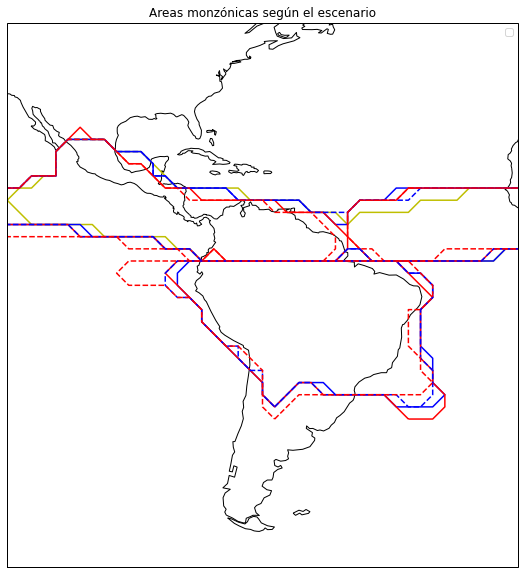

/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linestyle', 'label'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linestyle', 'label'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-pack

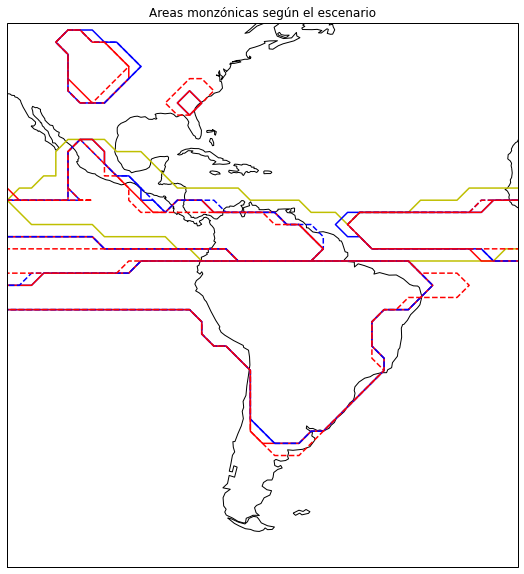

In [18]:
plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
area_nh_hist.plot.contour(levels=[0], cmap='y', linestyle='dotted', label='histórico')
area_nh_126_close.plot.contour(levels=[0], cmap='b', linestyle='solid', label='SSP126, cercano')
area_nh_585_close.plot.contour(levels=[0], cmap='r', linestyle='solid', label='SSP585, cercano')
area_nh_126_far.plot.contour(levels=[0], cmap='b', linestyles='dashed', label='SSP126, lejano')
area_nh_585_far.plot.contour(levels=[0], cmap='r', linestyles='dashed', label='SSP585, lejano')
area_sh_126_close.plot.contour(levels=[0], cmap='b', linestyle='solid')
area_sh_585_close.plot.contour(levels=[0], cmap='r', linestyle='solid')
area_sh_126_far.plot.contour(levels=[0], cmap='b', linestyles='dashed')
area_sh_585_far.plot.contour(levels=[0], cmap='r', linestyles='dashed')
ax.set_extent([-120, -15, -50, 35])
plt.title('Areas monzónicas según el escenario')
plt.legend()
#area_nh_126_close.plot.contour(levels=0)
ax.coastlines()
plt.show()

plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
area_nh_hist.plot.contour(levels=[0], cmap='y', linestyle='dotted', label='histórico')
area_nh_26_close.plot.contour(levels=[0], cmap='b', linestyle='solid', label='RCO26, cercano')
area_nh_85_close.plot.contour(levels=[0], cmap='r', linestyle='solid', label='RCO85, cercano')
area_nh_26_far.plot.contour(levels=[0], cmap='b', linestyles='dashed', label='RCO26, lejano')
area_nh_85_far.plot.contour(levels=[0], cmap='r', linestyles='dashed', label='RCO85, lejano')
area_sh_26_close.plot.contour(levels=[0], cmap='b', linestyle='solid')
area_sh_85_close.plot.contour(levels=[0], cmap='r', linestyle='solid')
area_sh_26_far.plot.contour(levels=[0], cmap='b', linestyles='dashed')
area_sh_85_far.plot.contour(levels=[0], cmap='r', linestyles='dashed')
ax.set_extent([-120, -15, -50, 35])
plt.title('Areas monzónicas según el escenario')
ax.coastlines()

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


[[0.0 0.0 0.0 ... 0.0 0.0 0.0] [12124.670693362816 12124.670693362816 12124.670693362816 ...  12124.670693362816 12124.670693362816 12124.670693362816] [24226.272326983202 24226.272326983202 24226.272326983202 ...  24226.272326983202 24226.272326983202 24226.272326983202] ... [24226.272326983202 24226.272326983202 24226.272326983202 ...  24226.272326983202 24226.272326983202 24226.272326983202] [12124.670693362816 12124.670693362816 12124.670693362816 ...  12124.670693362816 12124.670693362816 12124.670693362816] [0.0 0.0 0.0 ... 0.0 0.0 0.0]] meter
1005 meter ** 2 / kelvin / second ** 2
2501000.0 meter ** 2 / second ** 2


/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/pint/quantity.py:1160: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


joule / kilogram / second
joule / kilogram
(73, 144)
(73, 144)


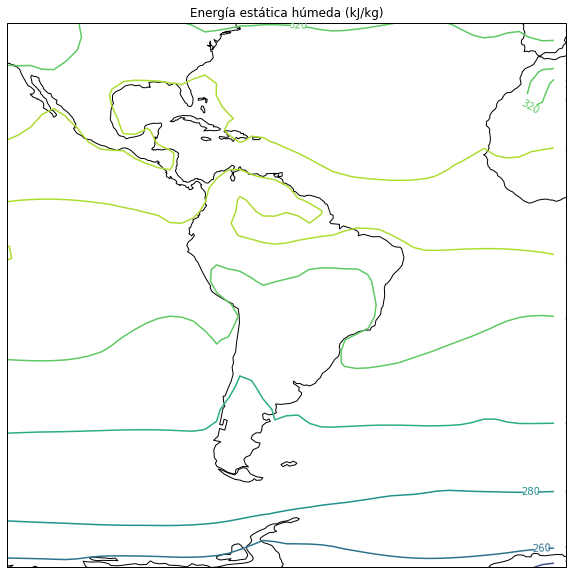

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/pint/quantity.py:1160: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


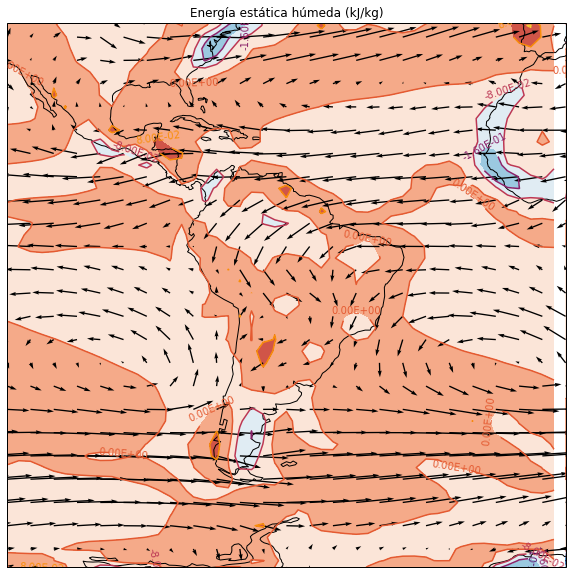

In [48]:
heights = 2 * np.ones((t_c6_hist['ds'].dims['lat'], t_c6_hist['ds'].dims['lon'])) * units.meter

t_c6_hist['mean_mjjas'].tas.attrs['units'] = 'kelvin'
temperature = t_c6_hist['mean_mjjas'].metpy.parse_cf('tas')
temperature.units
h_c5_hist['mean_mjjas'].huss.attrs['units'] = 'dimensionless'
humidity = h_c5_hist['mean_mjjas'].metpy.parse_cf('huss')

lon = t_c6_hist['ds'].lon
#        # lon['units'] = 'degrees'
lat = t_c6_hist['ds'].lat
#        #.values * units.degrees
u = u_ndjfm_hist.values * units['m/s']
v = v_ndjfm_hist.values * units['m/s']
dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)
print(dx)
print(mpconsts.Cp_d)
print(mpconsts.Lv)

moist_static_energy = mpcalc.moist_static_energy(heights=heights, temperature=temperature, specific_humidity=humidity).to('J/kg') 


plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
adv = mpcalc.advection(moist_static_energy, [u, v],
                       (dx, dy), dim_order='yx')

print(adv.units)
print(moist_static_energy.units)
print(u.shape)
print(v.shape)
ax.set_extent([-120, 0, -60, 25])
ploteo = plt.contour(lon, lat, moist_static_energy.to('kJ/kg'), transform=ccrs.PlateCarree()) #  vmax=30, vmin=-30,
plt.clabel(ploteo, inline=2, fontsize=10, fmt='%1d')
ax.coastlines()
plt.title('Energía estática húmeda (kJ/kg)')
plt.show()
#        ############# 
#        plt.figure(figsize=(20,10))
#        ax = plt.axes(projection=ccrs.PlateCarree())
#        adv = mpcalc.advection(moist_static_energy, [u, v],
#                               (dx, dy), dim_order='yx')
#        
#        plt.title('Advección de energía estática húmeda (W m$^{-2}$)')
#        print(adv.units)
#        print(moist_static_energy.units)
#        print(u.shape)
#        print(v.shape)
#        ax.set_extent([-120, 0, -60, 25])
#        ploteo = plt.contour(lon, lat, adv, vmax=30, vmin=-30, transform=ccrs.PlateCarree())
#        plt.clabel(ploteo, inline=2, fontsize=10)
#        ax.coastlines()
#        plt.show()
#        print(adv[10,20])
adv = adv_h(tas_ds=t_c6_hist['mean_ndjfm'], huss_ds=h_c6_hist['mean_ndjfm'], u_da=u_ndjfm_hist, v_da=v_ndjfm_hist)
plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-120, 0, -60, 25])
ploteo = plt.contour(lon, lat, adv, transform=ccrs.PlateCarree(), cmap='inferno')#  vmax=30, vmin=-30,
plt.contourf(lon, lat, adv, transform=ccrs.PlateCarree(), cmap='RdBu_r')
ax.quiver(u_ndjfm_hist.lon.values[0::2], u_ndjfm_hist.lat.values[0::2],
          u_ndjfm_hist.values[0::2, 0::2], v_ndjfm_hist.values[0::2, 0::2], scale=150)
plt.clabel(ploteo, inline=1, fontsize=10, fmt='%.2E')
ax.coastlines()
plt.title('Energía estática húmeda (kJ/kg)')
plt.show()


/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


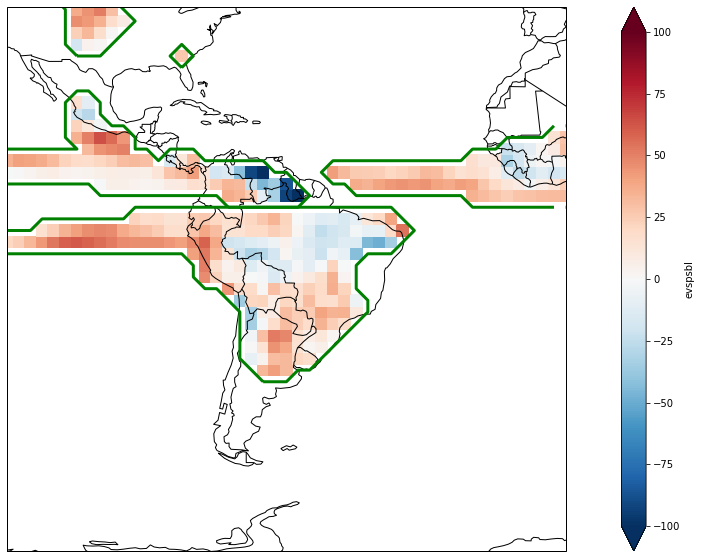

/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


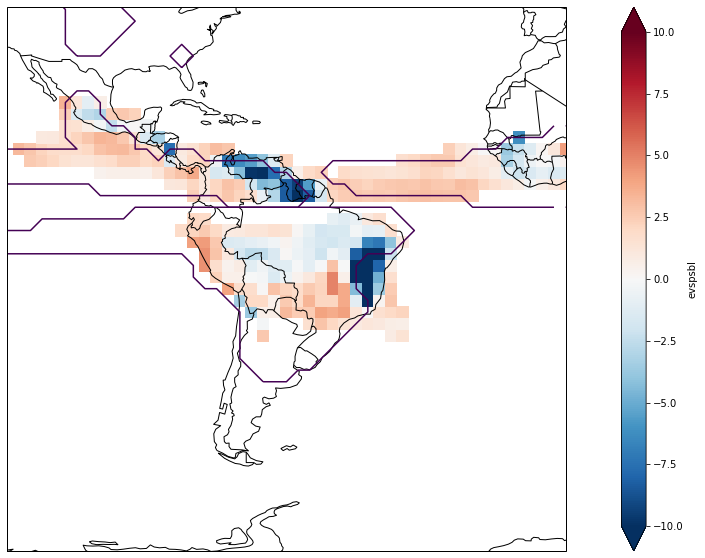

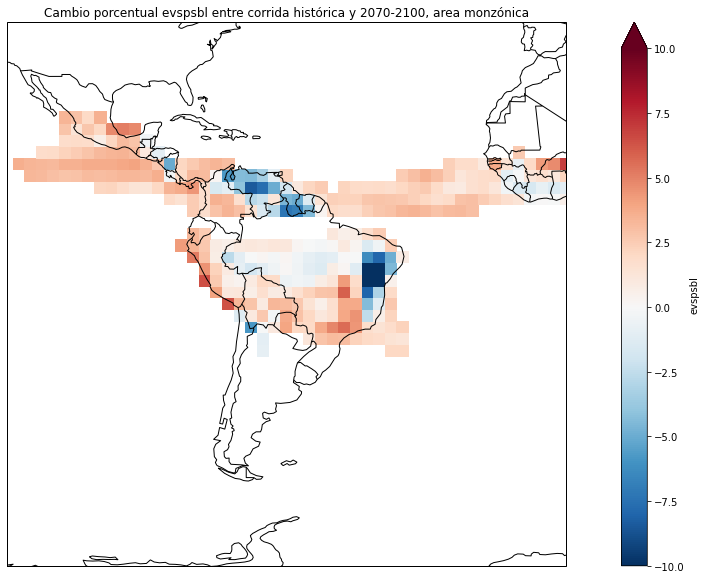

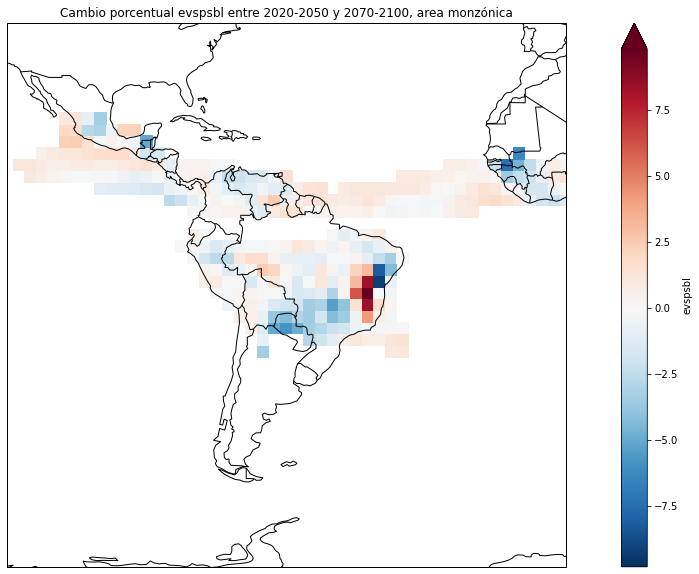

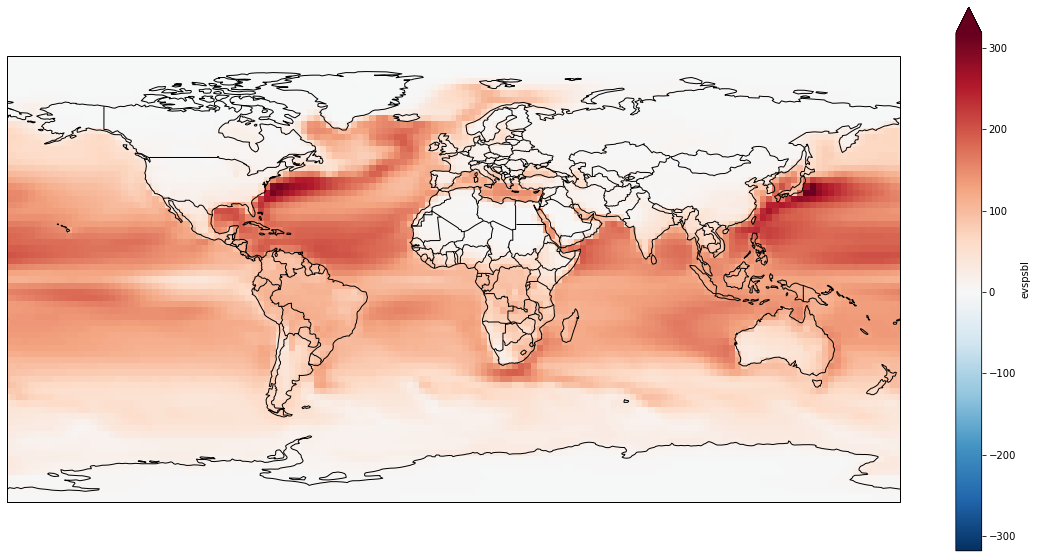

In [20]:
# print(e_c5_hist['ds'].time)
e5_hist = e_c5_hist['mean'].evspsbl
#ax = ploteo_general(e5_hist);
#ax.quiver(e_c5_hist['mean'].lon, e_c5_hist['mean'].lat, dq_dx, dq_dy)
#ax.set_extent([-120, 0, -60, 25])
#plt.show()
ax = ploteo_general(e_c5_26_close['mean'].evspsbl.where(area_sh_26_close + area_nh_26_close == 1) - e5_hist,
                    title='close', extend='both', vmin=-100, vmax=100, cmap='RdBu_r');
area_sh_26_close.plot.contour(levels=[0], linewidths=3, cmap='g')
area_nh_26_close.plot.contour(levels=[0], linewidths=3, cmap='g')
ax.set_extent([-120, 0, -60, 25])
plt.show()
ax = ploteo_general(200 * (e_c5_26_close['mean'].evspsbl.where((area_sh_hist + area_nh_hist) == 1) -
                      e5_hist.where(area_nh_hist + area_sh_hist == 1))/
               (e_c5_26_close['mean'].evspsbl + e5_hist), vmax=10, extend='both', under='none',
              title='Cambio porcentual evspsbl entre corrida histórica y 2020-2050, area monzónica')
area_sh_26_close.plot.contour(levels=[0], linewidth=3)
area_nh_26_close.plot.contour(levels=[0], linewidth=3)
ax.set_extent([-120, 0, -60, 25])
plt.show()
ax = ploteo_general(200 * (e_c5_26_far['mean'].evspsbl.where((area_sh_hist + area_nh_hist) == 1) -
                      e5_hist.where(area_nh_hist + area_sh_hist == 1))/
               (e_c5_26_far['mean'].evspsbl + e5_hist), vmax=10, under='none',
              title='Cambio porcentual evspsbl entre corrida histórica y 2070-2100, area monzónica')
ax.set_extent([-120, 0, -60, 25])
plt.show()
ax = ploteo_general(200 * (e_c5_85_far['mean'].evspsbl.where((area_sh_hist + area_nh_hist) == 1) -
                      e_c5_26_close['mean'].evspsbl.where(area_nh_hist + area_sh_hist == 1))/
               (e_c5_85_far['mean'].evspsbl + e_c5_26_close['mean'].evspsbl), under='none',
              title='Cambio porcentual evspsbl entre 2020-2050 y 2070-2100, area monzónica')
ax.set_extent([-120, 0, -60, 25])
plt.show()



ploteo_general(e_c6_hist['mean_ndjfm'].evspsbl)

/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


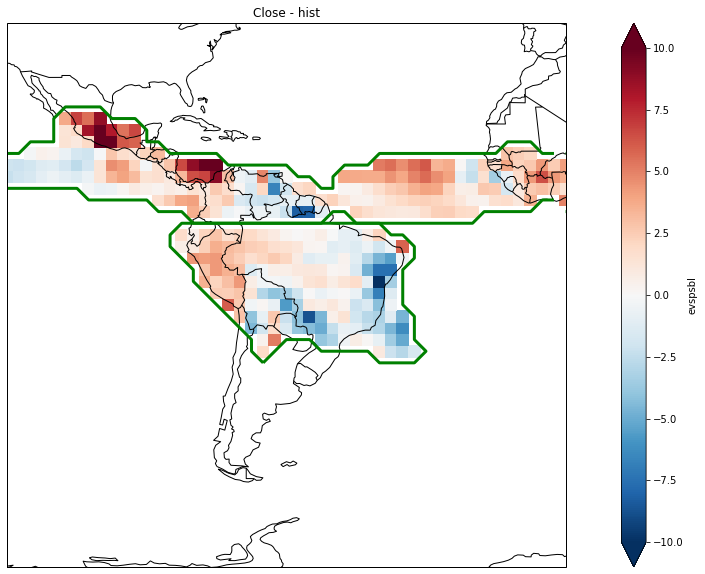

/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


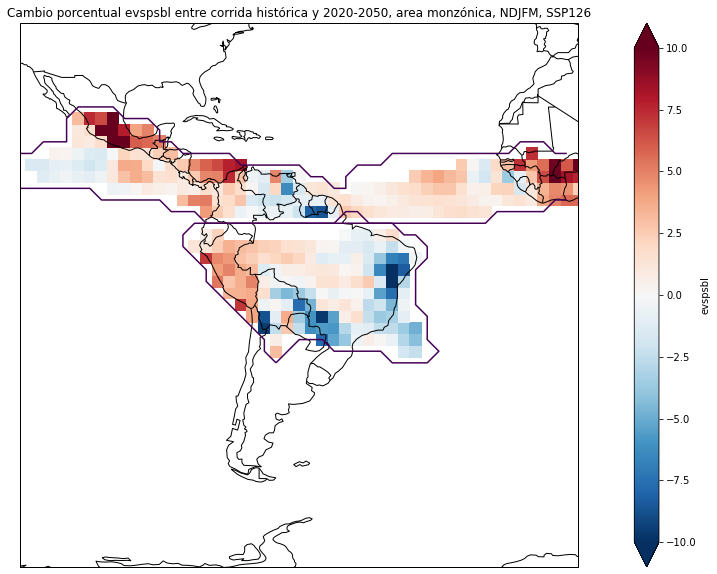

/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


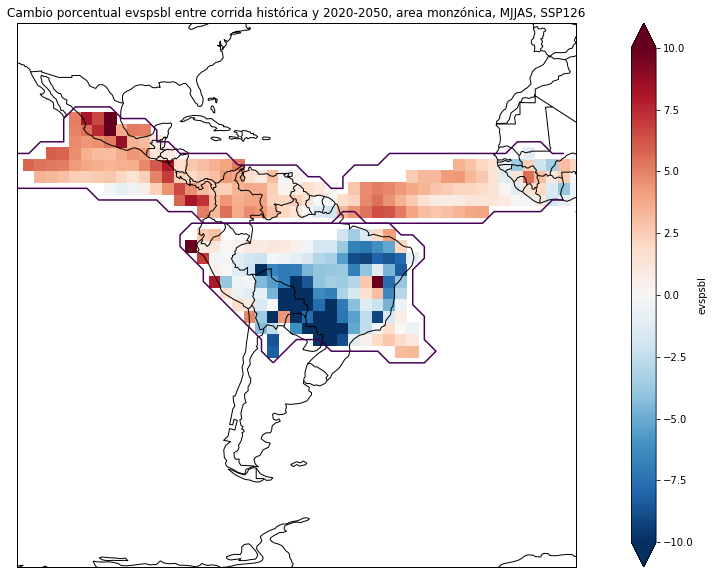

/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/tobi/programs/anaconda3/envs/metpy/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


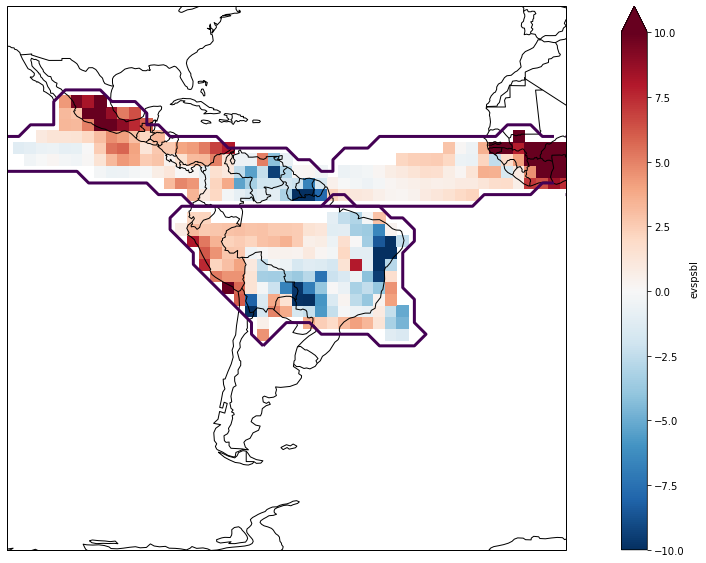

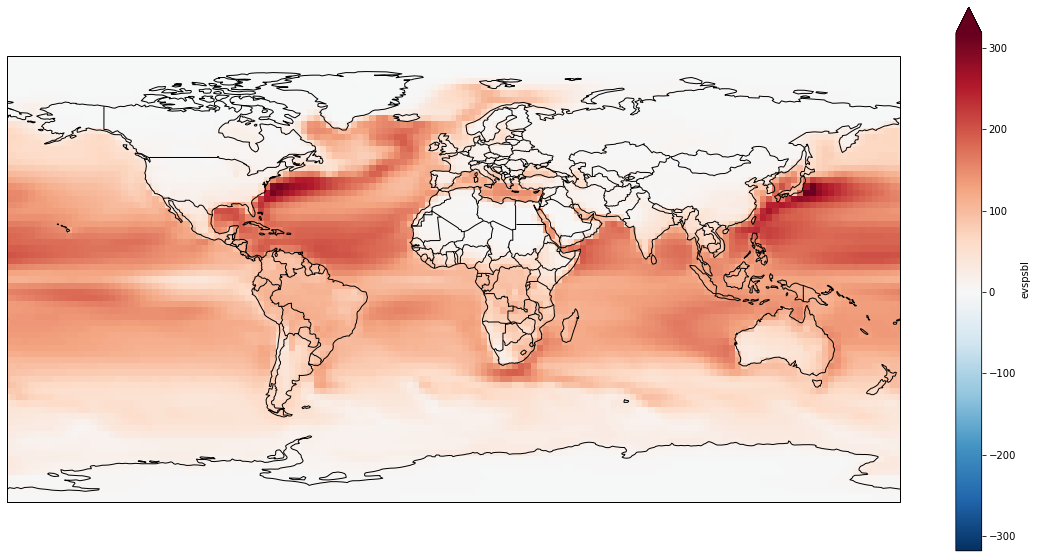

In [30]:
# print(e_c6_hist['ds'].time)
e5_hist = e_c6_hist['mean_ndjfm'].evspsbl
e5_hist_inv = e_c6_hist['mean_mjjas'].evspsbl
#ax = ploteo_general(e5_hist);
#ax.quiver(e_c6_hist['mean_ndjfm'].lon, e_c6_hist['mean_ndjfm'].lat, dq_dx, dq_dy)
#ax.set_extent([-120, 0, -60, 25])
#plt.show()
ax = ploteo_general(e_c6_126_close['mean_ndjfm'].evspsbl.where(area_sh_126_close + area_nh_126_close == 1) - e5_hist,
                    title='close', extend='both', vmin=-10, vmax=10, cmap='RdBu_r');
area_sh_126_close.plot.contour(levels=[0], linewidths=3, cmap='g')
area_nh_126_close.plot.contour(levels=[0], linewidths=3, cmap='g')
plt.title('Close - hist')
ax.set_extent([-120, 0, -60, 25])
plt.show()

ax = ploteo_general(200 * (e_c6_126_close['mean_ndjfm'].evspsbl.where((area_sh_hist + area_nh_hist) == 1) -
                      e5_hist.where(area_nh_hist + area_sh_hist == 1))/
               (e_c6_126_close['mean_mjjas'].evspsbl + e5_hist), vmax=10, extend='both', under='none',
              title='Cambio porcentual evspsbl entre corrida histórica y 2020-2050, area monzónica')
area_sh_126_close.plot.contour(levels=[0], linewidth=3)
area_nh_126_close.plot.contour(levels=[0], linewidth=3)
plt.title('Cambio porcentual evspsbl entre corrida histórica y 2020-2050, area monzónica, NDJFM, SSP126')
ax.set_extent([-120, 0, -60, 25])
plt.show()

ax = ploteo_general(200 * (e_c6_126_close['mean_mjjas'].evspsbl.where((area_sh_hist + area_nh_hist) == 1) -
                      e5_hist_inv.where(area_nh_hist + area_sh_hist == 1))/
               (e_c6_126_close['mean_mjjas'].evspsbl + e5_hist_inv), vmax=10, extend='both', under='none',
              title='Cambio porcentual evspsbl entre corrida histórica y 2020-2050, area monzónica')
area_sh_126_close.plot.contour(levels=[0], linewidth=3)
area_nh_126_close.plot.contour(levels=[0], linewidth=3)
plt.title('Cambio porcentual evspsbl entre corrida histórica y 2020-2050, area monzónica, MJJAS, SSP126')
ax.set_extent([-120, 0, -60, 25])
plt.show()
#       ax = ploteo_general(200 * (e_c6_585_close['mean_ndjfm'].evspsbl.where((area_sh_hist + area_nh_hist) == 1) -
#                             e_c6_126_close.where(area_nh_hist + area_sh_hist == 1))/
#                      (e_c6_126_close['mean_ndjfm'].evspsbl + e_c6_585_close), vmax=10, extend='both', under='none',
#                     title='Cambio porcentual evspsbl entre SSP585-SSP126 y 2020-2050, area monzónica')
#       area_sh_126_close.plot.contour(levels=[0], linewidth=3)
#       area_nh_126_close.plot.contour(levels=[0], linewidth=3)
#       ax.set_extent([-120, 0, -60, 25])
#       plt.show()

ax = ploteo_general(200 * (e_c6_126_far['mean_ndjfm'].evspsbl.where((area_sh_hist + area_nh_hist) == 1) -
                      e5_hist.where(area_nh_hist + area_sh_hist == 1))/
               (e_c6_126_far['mean_ndjfm'].evspsbl + e5_hist), vmax=10, under='none',
              title='Cambio porcentual evspsbl entre corrida histórica y 2070-2100, area monzónica')
area_sh_126_close.plot.contour(levels=[0], linewidths=3)
area_nh_126_close.plot.contour(levels=[0], linewidths=3)
ax.set_extent([-120, 0, -60, 25])
plt.show()
#ax = ploteo_general(200 * (e_c6_585_far['mean_ndjfm'].evspsbl.where((area_sh_hist + area_nh_hist) == 1) -
#                      e_c6_126_close['mean_ndjfm'].evspsbl.where(area_nh_hist + area_sh_hist == 1))/
#               (e_c6_585_far['mean_ndjfm'].evspsbl + e_c6_126_close['mean_ndjfm'].evspsbl), under='none',
#              title='Cambio porcentual evspsbl entre 2020-2050 y 2070-2100, area monzónica')
#ax.set_extent([-120, 0, -60, 25])
#plt.show()



ploteo_general(e_c6_hist['mean_ndjfm'].evspsbl)